#  <font color='black'>Notes</font>

Author: Huan Q. Bui

Affiliation: Massachusetts Institute of Technology,
             BEC1 Ultracold Quantum Gases experiment
             
PI: Professor Martin Zwierlein

First updated: Feb 07, 2023

Last updated: Mar 08, 2023

To do:
- Comb through notebook, implement more clever ways to extract arrays from df (check whenever we use df.iterrows..)
- In-situ box analysis
    - implement data filter... classify shots as good/bad etc.
- Implement saving of analysis df's
- Write up on the theory of polarization rotation imaging. INCLUDE BEC1-related caveats!
- Hybrid Top analysis:
    - Thermometry from hybrid top analysis. This is REALLY IMPORTANT!!!
- Rapid ramp analysis (condensate fraction fit)
- Na BEC fitting (condensate fraction fit)
- Li MT LF thermometry. This is a good starting point for hybrid trap thermometry.
- Simulate compressible fluid in a box with a perturbing side wall?
- Breit Rabi calculator

#  <font color='black'>Setting up</font>

##  <font color=#399FD5>Collapsible Headings and Initialization Cells</font>

Run the following commands in anaconda prompt to install a graphical interface for configuring collapsible headings and other extentions/plugins from within the notebooks:

pip install jupyter_contrib_nbextensions
jupyter contrib nbextension install --user
jupyter nbextensions_configurator enable --user

Once done, go to Jupyter notebook --> Nbextensions --> check the "Collapsible Headings" box

Can also turn on "Initialization cell" in Jupyter Notebook extension settings. 
Then go to View/Cell Toolbar/Initialization Cell and check cells that will be run on startup

## <font color=#399FD5>Imports and Parallel Computing Setup</font>

In [106]:
from tkinter import Tk
from tkinter import filedialog # for prompting user to set analysis folder
import glob
import json
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import scipy
from scipy.optimize import fsolve
from scipy.fft import fft, fftfreq
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import math
import cython
import numba
import shutil
import time

In [35]:
# for parallel processing
import contextlib
import joblib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

## <font color=#399FD5>Suppress Warnings</font>

In [36]:
import warnings
warnings.filterwarnings('ignore')

## <font color=#399FD5>Constants</font>

In [37]:
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724 # MHz. Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)

# Sodium constants
mNa23 = 0.381754035*10**(-25) # kg 

# Utility functions

## <font color=#399FD5>Get run parameters</font>

In [38]:
def get_run_param_from_filename(folder_path, current_file_fullpath, metadata_dict = dict(), param = ''):
    '''
    get a single parameter value from a file, if metadata)dict exists:
    '''
    param_for_filename = 0
    name = str(current_file_fullpath.split(folder_path)[1]).replace('\\',"")
    run_id = name.split('_')[0]
    run_id = "".join(ch for ch in run_id if ch.isalnum() ) # extract run_id out of folder name
    # get params for this run_id
    if bool(metadata_dict):
        params_for_run_id = metadata_dict[run_id]
        param_for_filename = params_for_run_id[param]
    return param_for_filename

In [39]:
def get_run_params_for_data_frame(folder_path, metadata_dict = dict(), params = []):
    '''
    params: list of param names [p1,p2,...]
    returns a dictionary of the form {p1: [], p2: [],...}
    '''
    params_for_folder = dict() # this is a dict() of lists
    # initial params_for_folder:
    if params != []:
        for p in params:
            params_for_folder[p] = []
    if bool(metadata_dict): 
        for f in sorted(glob.glob(folder_path + '/*.fits')): # for every fits file in folder
            name = str(f.split(folder_path)[1]).replace('\\',"")
            run_id = name.split('_')[0] 
            run_id = "".join(ch for ch in run_id if ch.isalnum() )
            # get params for this run_id
            params_for_run_id = metadata_dict[run_id]
            for k in params_for_folder.keys():
                params_for_folder[k].append(params_for_run_id[k])
                
    return params_for_folder

### EXAMPLE CODE: ####
# params = get_run_params(folder_path, params = ['LFImgFreq', 'SideGreenEvap', 'IREvap'])

## <font color=#399FD5>Initialize data frame</font>

In [40]:
def init_dataframe_metadata_and_exp_params(optional_parameter_list = []):

    folder_path = filedialog.askdirectory()
    metadata_dict = dict()
    experiment_parameters_dict = dict()
    
    # load metadata if avalable:
    metadata_fullpath_load_status = False
    metadata_fullpath = folder_path + "/run_params_dump.json"
    if os.path.isfile(metadata_fullpath):
        metadata_fullpath_load_status = True
        with open(metadata_fullpath, 'r') as json_file:
            metadata_dict = json.load(json_file)  

    # load experiment_parameters if avaiable:
    experiment_parameters_fullpath_load_status = False
    experiment_parameters_fullpath = folder_path + "/experiment_parameters.json"
    if os.path.isfile(experiment_parameters_fullpath):
        experiment_parameters_fullpath_load_status = True
        with open(experiment_parameters_fullpath, 'r') as json_file:
            experiment_parameters_dict = json.load(json_file)  
            
    # construct data frame with full paths:
    image_list = sorted(glob.glob(folder_path + '/*.fits'))
    data_frame = pd.DataFrame(data = {'fullpaths' : image_list})
    # add good/bad shot status to dataframe... will modify later if necessary:
    data_frame['good_shot'] = [True for i in range(len(image_list))]
    
    # get file names for readability and attach to data frame:
    # also get image type: TopA, TopB, Side
    run_ids = []
    image_type = []
    ImagFreq1 = []
    ImagFreq2 = []
    LFImgFreq = []
    for f in image_list:
        # add run_id
        name = str(f.split(folder_path)[1]).replace('\\',"")
        run_id = name.split('_')[0] 
        run_id = "".join(ch for ch in run_id if ch.isalnum() )
        run_ids.append(run_id)

        # add image type
        if 'TopA' in name:
            image_type.append('TopA')
        elif 'TopB' in name:
            image_type.append('TopB')
        elif 'Side' in name:
            image_type.append('Side')

        # add ImagFreq, only if metadata_dict is available:
        if bool(metadata_dict):
            ImagFreq1.append(get_run_param_from_filename(folder_path, f, metadata_dict, 'ImagFreq1'))
            ImagFreq2.append(get_run_param_from_filename(folder_path, f, metadata_dict, 'ImagFreq2'))
            LFImgFreq.append(get_run_param_from_filename(folder_path, f, metadata_dict, 'LFImgFreq'))
                    
    data_frame['run_id'] = run_ids
    data_frame['image_type'] = image_type
    if bool(metadata_dict):
        data_frame['ImagFreq1'] = ImagFreq1
        data_frame['ImagFreq2'] = ImagFreq2
        data_frame['LFImgFreq'] = LFImgFreq
    
    # add relevant parameters to dataframe... can always add more later:
    run_params = get_run_params_for_data_frame(folder_path, metadata_dict, optional_parameter_list)
    # add data to dataframe:
    if bool(run_params):
        for param in run_params.keys():
            data_frame[param] = run_params[param]
    
    ##################################################
    ############## PRINT OUT STATUS ##################
    ##################################################

    print('Current folder: ' + folder_path)
    if metadata_fullpath_load_status:
        print('Metadata loaded')
    else:
        print('No metadata to load') 
    if experiment_parameters_fullpath_load_status:
        print('Experiment parameters loaded')
    else:
        print('No experiment parameters to load')
    print('Data frame initialized!')

    return (data_frame, metadata_dict, experiment_parameters_dict)

## <font color=#399FD5>Display image</font>

In [41]:
# function for safely handling subtractions...
# Credit: Eric A. Wolf, BEC1@MIT, 2022. 

def safe_subtract(x, y, minimum_cast = np.byte):
    newtype = np.result_type(x, y, minimum_cast)
    return x.astype(newtype) - y.astype(newtype)

In [42]:
# display an image given folder_path, run_id, ROI, and frame_type:
def display_image(current_file_fullpath, ROI, norm_box, 
                  frame_type = 'FakeOD', min_scale=0, max_scale=1.3, brightness=12):
    # set up figure
    fig, ax = plt.subplots()
    
    # read image
    fits_image = fits.open(current_file_fullpath)
    # fits_image.info() # display fits image info
    img = fits_image[0].data
    fits_image.close()

    # get dims of image
    dims = img[0,:,:].shape 
    x_limit = dims[1]
    y_limit = dims[0]

    # then show image:
    if frame_type == 'OD':
        frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
        # clean image: using nan_to_num
        frame = np.nan_to_num(frame, nan=ABSORPTION_LIMIT)
        # fix clipping
        frame = np.clip(frame, 0, ABSORPTION_LIMIT)
        ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
        ax.invert_yaxis()

    else:
        if frame_type == 'FakeOD':
            frame = (safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:]))
            # clean image: using nan_to_num
            frame = np.nan_to_num(frame)
            # fix clipping
            frame = np.clip(frame, 0, ABSORPTION_LIMIT)
            ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
            ax.invert_yaxis()
        else:
            if frame_type == 'With atoms':
                frame = img[0,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Without atoms':
                frame = img[1,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Dark':
                frame = img[2,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            else:
                frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
                ax.invert_yaxis()
                
    # Create a roi patch
    width = abs(int(ROI[1]) - int(ROI[0]))
    height = abs(int(ROI[3]) - int(ROI[2]))
    xmin = min(int(ROI[0]), int(ROI[1]))
    ymin = min(int(ROI[2]), int(ROI[3]))
    roi = patches.Rectangle((xmin, ymin), 
                             width, 
                             height, 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    
    # Create a norm_box patch
    width_norm = abs(int(norm_box[1]) - int(norm_box[0]))
    height_norm = abs(int(norm_box[3]) - int(norm_box[2]))
    xmin_norm = min(int(norm_box[0]), int(norm_box[1]))
    ymin_norm = min(int(norm_box[2]), int(norm_box[3]))
    
    norm_roi = patches.Rectangle((xmin_norm, ymin_norm), 
                             width_norm, 
                             height_norm, 
                             linewidth=1, 
                             edgecolor='g', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    ax.add_patch(norm_roi)   
    
    # add center of ROI box to image:
    ROI_center = [(ROI[2] + ROI[3])//2, (ROI[0] + ROI[1])//2]
    ax.scatter([ROI_center[1]],[ROI_center[0]], marker='.', color = 'red', s=1)
    
    # show everything
    plt.show()
                
    return (fig, ax)

## <font color=#399FD5>Add normalized FakeOD to dataframe</font>

In [43]:
def get_fakeOD_cropped(current_file_fullpath, ROI, norm_box):
    
    # memmapping:
    with fits.open(current_file_fullpath, memmap = True, do_not_scale_image_data = True) as fits_image:
        img = fits_image[0].data
    
    # read image
    #fits_image = fits.open(current_file_fullpath)
    #img = fits_image[0].data
    #fits_image.close()
    
    # get fakeOD image and crop it
    wa_roi   = img[0, ROI[2]:ROI[3], ROI[0]:ROI[1]]
    woa_roi  = img[1, ROI[2]:ROI[3], ROI[0]:ROI[1]]
    dark_roi = img[2, ROI[2]:ROI[3], ROI[0]:ROI[1]]
    wa_roi   = wa_roi.astype(float)
    woa_roi  = woa_roi.astype(float)
    dark_roi = dark_roi.astype(float)
    
    wa_nb   = img[0, norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    woa_nb  = img[1, norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    dark_nb = img[2, norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    wa_nb   = wa_nb.astype(float)
    woa_nb  = woa_nb.astype(float)
    dark_nb = dark_nb.astype(float)
    
    wa_over_woa_factor = sum(sum(wa_nb))/sum(sum(woa_nb))
    adjusted_woa_roi = woa_roi*wa_over_woa_factor
        
    fakeOD = safe_subtract(wa_roi, dark_roi)/safe_subtract(adjusted_woa_roi,dark_roi)
    
    return fakeOD

In [44]:
def add_backgroud_subtracted_ROI_to_dataframe_fast(df, ROI, norm_box): 

    # now add fakeOD with background subtraction to dataframe:
    fake_od_background_subtracted_roi = []
    #for f in tqdm(df['fullpaths']):
    #    fake_od_background_subtracted_roi.append(get_fakeOD_cropped(f, ROI, norm_box))
        
    with tqdm_joblib(tqdm(desc="Loading ROIs", total = len(df['fullpaths']))) as progress_bar:
        fake_od_background_subtracted_roi = Parallel(n_jobs=-2)(delayed(get_fakeOD_cropped)(df['fullpaths'][i],
                                                                                            ROI, 
                                                                                            norm_box) 
                                                 for i in range(len(df['fullpaths'])))
    
    # once done, delete temp folder
    if os.path.exists('temp_data'):
        print('Deleting temporary folder...')
        shutil.rmtree('temp_data')
    print('All done.')
    
    # update dataframe:
    df['fakeOD_roi'] = fake_od_background_subtracted_roi
    
    return df

## <font color=#399FD5>Pixel summing</font>

In [45]:
def add_pixel_sums_to_data_frame_from_FakeOD_ROI(df):
    if 'fakeOD_roi' in df.columns:
        pixel_sums = []
        for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
            # first compute od from cleaned fakeOD:
            od = -np.log(row['fakeOD_roi'])
            # now clean od:
            od = np.nan_to_num(od)
            # fix clipping
            od = np.clip(od, 0, ABSORPTION_LIMIT)
            od = od.astype(np.float)

            pixel_sums.append(sum(sum(od)))

        # update dataframe:
        df['pixel_sum'] = pixel_sums
    return df

## <font color=#399FD5>Get atom densities from absorption images</font>

Some theory for atom counting. The 2D atom density, including the effect of saturation, is given by 

$n_{2d}(x,y) = \int n_{3d}(x,y,z)\,dz = -\frac{1+I/I_\text{sat}(\omega)}{\sigma(\omega)} \ln \frac{I_f}{I_0} = \frac{1+s\sigma(\omega)/\sigma_0}{\sigma(\omega)} \times \text{OD}, $ 

where $\kappa(\omega, I) = \frac{n_{2d} \sigma(\omega)}{1 + I / I_\text{sat}(\omega)}$ is the absorption coefficient, 
$\sigma(\omega) = \sigma_0 \frac{\Gamma^2/4}{(\omega-\omega_0)^2 + \Gamma^2/4}$, and $\sigma_0 = \frac{3\lambda_0^2}{2\pi}$.

So, after the fit has been done, we know $\omega_0$ and $s$. Since $\sigma_0$ is known, we can calculate $(1+s \sigma(\omega)/\sigma_0)/\sigma(\omega)$ for every shot. From here, we can obtain $n_{2d}$ from knowing the OD (which comes from the image). Finally, to obtain the atom number, we just multiply the atom density $n_{2d}$ by the pixel size and integrate over the entire image to get $N$. 

Notice that we have not considered the fact that for (nearly) blacked out clouds the saturation parameter changes as a function of the line of integration. How might we take this into account? Consider the Beer-Lambert law, which says 

$ \frac{dI}{I} = -\kappa(I, \omega) \,dz = -n\sigma_0 \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,dz \implies \int_{s_0}^{s_f} \frac{1}{s} \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,ds =  -n_{2d}\sigma_0 $.

where we have made the substitution $I \to s I_\text{sat},  I_0 \to s_0 I_\text{sat}, I_f \to s_f I_\text{sat}$ and integrated both sides, simplifying the integrand, we find that

$-n_{2d} \sigma_0 =  \int_{s_0}^{s_f} 1 + \frac{1 + 4\delta^2/\Gamma^2}{s}\,ds = (s_f - s_0) + \left( 1 + \frac{4\delta^2}{\Gamma^2} \right)\ln \frac{s_f}{s_0}.$

From here, the atom density is readily found:

$\boxed{n_{2d} = -\frac{1}{\sigma_0} \left[ \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \ln \frac{I_f}{I_0} +  \frac{I_f - I_0}{I_\text{sat}}\right] =  \frac{1}{\sigma_0} \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \times od  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} = \frac{od}{\sigma(\omega)}  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} } $

One final thing: how do we obtain $I_\text{sat}$? There are several ways to do this, but one way is to obtain the saturation parameter $s$ from the imaging resonance curve fit, and then take the without atom shot and divide it by $s$ to get an approximation for $I_\text{sat}$. 

Since the second term is typically much smaller than the first, in the interest of simplifying and making the analysis code faster we will drop it. 

In [46]:
def add_atom_densities_abs_to_data_frame_Side_LF_fast(df, 
                                                      sigma0 = Li6D2sigma0,
                                                      Gamma = Li6D2Gamma, 
                                                      s = 0, 
                                                      omega0 = 0,
                                                      AOM_factor = -2):
    # for now handle saturation parameter separately from data frame
    '''
    s: saturation parameters, default to 0
    Assumes that df already has 'LFImgFreq'
    '''
    n2d = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        sigma = sigma0 * (Gamma**2/4) / ( (AOM_factor*(omega0 - row['LFImgFreq']))**2 + Gamma**2/4 )
        # first compute od from cleaned fakeOD:
        od = -np.log(row['fakeOD_roi'])
        # now clean od:
        od = np.nan_to_num(od)
        # fix clipping
        od = np.clip(od, 0, ABSORPTION_LIMIT)
        od = od.astype(np.float)
        # n2d = od/sigma(omega)
        n2d.append(od/sigma)
        
    df['column_density'] = n2d
    
    return df

In [47]:
def add_atom_densities_abs_to_data_frame_TopAB_fast(df, 
                                                    sigma0 = Li6D2sigma0,
                                                    Gamma = Li6D2Gamma, 
                                                    s_A = 0, s_B = 0,
                                                    omega0_A = 0, omega0_B = 0,
                                                    AOM_factor = -2):
    
    # for now handle saturation parameter separately from data frame
    '''
    s_A, s_B: saturation parameters, default to 0
    For now, the saturation parameters are not used
    Assumes that df already has 'ImagFreq1' and 'ImagFreq2'
    '''
    # since imaging from top is not along quantization axis, cross section is reduced by 2
    top_imaging_factor = 0.5
    sigma0 = sigma0 * top_imaging_factor
    
    n2d = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        if row['image_type'] == 'TopA':
            sigma = sigma0 * (Gamma**2/4) / ((AOM_factor*(omega0_A - row['ImagFreq1']))**2 + Gamma**2/4 )        
        elif row['image_type'] == 'TopB':
            sigma = sigma0 * (Gamma**2/4) / ((AOM_factor*(omega0_B - row['ImagFreq2']))**2 + Gamma**2/4 )
        else:
            print('NOT YET SUPPORTED!')
        # first compute od from cleaned fakeOD:
        od = -np.log(row['fakeOD_roi'])
        # now clean od:
        od = np.nan_to_num(od)
        # fix clipping
        od = np.clip(od, 0, ABSORPTION_LIMIT)
        od = od.astype(np.float)
        
        # n2d = od/sigma(omega)
        n2d.append(od/sigma)

    # update dataframe
    df['column_density'] = n2d   

    return df

## <font color=#399FD5>Polarization Rotation Imaging Functions</font>

### <font color='6C828D'>Theory of Polarization Rotation Imaging</font>

Some theory on polarization rotation imaging (PRI), due to Parth Patel's PhD thesis (BEC1 experiment at MIT, advised by Martin Zwierlein). In contrast to absorption imaging which uses only the absorption of light to infer the optical density ($od$) of an atomic sample, PRI uses both absorption and phase shift of the imaging light to obtain $od$. Along with other benefits, PRI is particularly good for obtaining $od$'s of optically densed samples (aka blacked-out clouds). 

The imaging light used in PRI is off-resonant ($\delta \gtrsim \Gamma$) in order to enhance the atom's induced phase shift, which is proportional to $\delta/\Gamma$, and minimize absorption. 

### <font color='6C828D'>Polarization Rotation Imaging Functions</font>

In [48]:
@numba.jit(nopython=True, cache=True)
def polrot_equations(actual_ods, *params):
        
    od0_1, od0_2 = actual_ods
    
    observed_fakeOD_A, observed_fakeOD_B, detuning_A_1, detuning_A_2, detuning_B_1, detuning_B_2, phase_sign, Li6D2Gamma = params
    
    odA_1 = od0_1 / (1 + pow(2*detuning_A_1/Li6D2Gamma,2))
    odA_2 = od0_2 / (1 + pow(2*detuning_A_2/Li6D2Gamma,2))
    odB_1 = od0_1 / (1 + pow(2*detuning_B_1/Li6D2Gamma,2))
    odB_2 = od0_2 / (1 + pow(2*detuning_B_2/Li6D2Gamma,2))
    
    aA = math.exp( -(odA_1 + odA_2)/2.0)
    aB = math.exp( -(odB_1 + odB_2)/2.0)
    phiA = phase_sign*(-detuning_A_1*odA_1 - detuning_A_2*odA_2)/Li6D2Gamma
    phiB = phase_sign*(-detuning_B_1*odB_1 - detuning_B_2*odB_2)/Li6D2Gamma
    
    return ( (1/2 + aA**2/2) - aA*math.sin(phiA) - observed_fakeOD_A, 
             (1/2 + aB**2/2) - aB*math.sin(phiB) - observed_fakeOD_B )

In [49]:
def polrot_solve(fake_OD_roi_A, fake_OD_roi_B, detuning_A_1, detuning_A_2, detuning_B_1, detuning_B_2, polrot_phase_sign, height, width):   
    
    # prepare od0_1 and od0_2:
    od0_1 = np.empty([height, width])
    od0_2 = np.empty([height, width])
    
    # now process:
    for h in range(height):
        for w in range(width):
            od0_1[h][w], od0_2[h][w] =  fsolve(polrot_equations, 
                                               (0,0), # this is a fakeOD guess 
                                               args = (fake_OD_roi_A[h][w], 
                                                       fake_OD_roi_B[h][w], 
                                                       detuning_A_1, 
                                                       detuning_A_2, 
                                                       detuning_B_1, 
                                                       detuning_B_2,
                                                       polrot_phase_sign,
                                                       Li6D2Gamma),
                                               xtol=1e-09, 
                                               maxfev=1000)
    return od0_1, od0_2

In [50]:
def add_polrot_column_densities_to_dataframe(df_PR, exp_params_dict_PR, ROI_PR):

    # get imaging parameters:
    state_1_unitarity_res_freq_MHz = exp_params_dict_PR["Values"]['state_1_unitarity_res_freq_MHz']
    state_3_unitarity_res_freq_MHz = exp_params_dict_PR["Values"]['state_3_unitarity_res_freq_MHz']
    li_hf_freq_multiplier = exp_params_dict_PR["Values"]["li_hf_freq_multiplier"]
    polrot_phase_sign = exp_params_dict_PR["Values"]["polrot_phase_sign"]
    
    # these variables are added recently:
    hf_lock_setpoint = 0
    hf_lock_unitarity_resonance_value = 0
    if "hf_lock_setpoint" in exp_params_dict_PR["Values"] and "hf_lock_unitarity_resonance_value" in exp_params_dict_PR["Values"]:
        hf_lock_setpoint = exp_params_dict_PR["Values"]["hf_lock_setpoint"]
        hf_lock_unitarity_resonance_value = exp_params_dict_PR["Values"]["hf_lock_unitarity_resonance_value"]

    # calculate imaging parameters to 
    omega0_1 = state_1_unitarity_res_freq_MHz # resonance freq for state 1
    omega0_2 = state_3_unitarity_res_freq_MHz # resonance freq for state 3
    omega_A  = (df_PR['ImagFreq1'][0] - (hf_lock_setpoint-hf_lock_unitarity_resonance_value)/li_hf_freq_multiplier ) # assuming ImagFreq does not change
    omega_B  = (df_PR['ImagFreq2'][0] - (hf_lock_setpoint-hf_lock_unitarity_resonance_value)/li_hf_freq_multiplier) # assuming ImagFreq does not change

    detuning_A_1 = (-omega0_1 + omega_A)*li_hf_freq_multiplier
    detuning_A_2 = (-omega0_2 + omega_A)*li_hf_freq_multiplier
    detuning_B_1 = (-omega0_1 + omega_B)*li_hf_freq_multiplier
    detuning_B_2 = (-omega0_2 + omega_B)*li_hf_freq_multiplier

    # get size of ROI:
    height = ROI_PR[3] - ROI_PR[2]
    width  = ROI_PR[1] - ROI_PR[0] 

    # shouldn't pass the entire data frame to processes... since there's a lot of extra info that we won't need:
    # instead make list of images:
    fake_OD_roi_A = []
    fake_OD_roi_B = []
    
    # implement clever...
    for i in range(0, len(df_PR), 2):
        if df_PR['image_type'][i] == 'TopA' and df_PR['image_type'][i+1] == 'TopB':
            fake_OD_roi_A.append(df_PR['fakeOD_roi'][i])
            fake_OD_roi_B.append(df_PR['fakeOD_roi'][i+1])
        elif df_PR['image_type'][i] == 'TopB' and df_PR['image_type'][i+1] == 'TopA':
            fake_OD_roi_A.append(df_PR['fakeOD_roi'][i+1])
            fake_OD_roi_B.append(df_PR['fakeOD_roi'][i])
                    
    with tqdm_joblib(tqdm(desc="Solving images", total= len(df_PR)//2)) as progress_bar:
        results = Parallel(n_jobs=-2)(delayed(polrot_solve)(fake_OD_roi_A = fake_OD_roi_A[i], 
                                                            fake_OD_roi_B = fake_OD_roi_B[i],
                                                            detuning_A_1 = detuning_A_1, 
                                                            detuning_A_2 = detuning_A_2, 
                                                            detuning_B_1 = detuning_B_1, 
                                                            detuning_B_2 = detuning_B_2, 
                                                            polrot_phase_sign = polrot_phase_sign,
                                                            height = height, 
                                                            width = width) 
                                      for i in range(len(df_PR)//2))
    # remember that factor of 2 reduction in the cross section when imaging from Top:
    PR_densities = []
    for r in results:
        PR_densities.append(r[0]/(Li6D2sigma0/2))
        PR_densities.append(r[1]/(Li6D2sigma0/2))
    df_PR['column_density'] = PR_densities
    
    return df_PR

In [51]:
def add_counts_from_PR_column_densities_to_dataframe(df_PR, um_per_pixel):
    counts = []
    for idx, row in df_PR.iterrows():
        counts.append( sum(sum(row['column_density']))* (um_per_pixel**2) * 10**(-12) )
    df_PR['atom_count'] = counts
    return df_PR

## <font color=#399FD5>Get atom counts from densities</font>

In [52]:
def add_atom_counts_from_densities_to_data_frame(df, um_per_pixel):
    '''
    um_per_pixel is, obviously, in um
    we have to convert this to m, since sigma0 is in m^2
    '''
    counts = []
    for index, row in df.iterrows():
        counts.append(sum(sum(row['column_density'])) * (um_per_pixel**2) * 10**(-12))
    df['atom_count'] = counts
    return df

## <font color=#399FD5>Hybrid Top analysis functions</font>

In [53]:
# rotate column densities by tilt angle & add 'justified_column_density' to dataframe
def add_justified_column_density_to_dataframe(df, tilt_angle):
    df['justified_column_density'] = [None]*df.shape[0]
    
    print('Tilt angle: ' + str(tilt_angle) + ' degrees')
    
    if 'column_density' in df.columns:
        for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
            if tilt_angle != 0:
                df.at[idx, 'justified_column_density'] = scipy.ndimage.rotate(input = row['column_density'],
                                                                              angle = tilt_angle, 
                                                                              reshape = False)
            else:
                df.at[idx, 'justified_column_density'] = row['column_density']
    return df

In [54]:
# Add 3d densities along harmonic axis of hybrid trap to dataframe
def add_n3d_along_harmonic_axis_to_dataframe(df, exp_params_dict):
    # box dimensions:
    axicon_diameter_pix = exp_params_dict["Values"]["axicon_diameter_pix"]
    axicon_length_pix = exp_params_dict["Values"]["hybrid_trap_typical_length_pix"]
    um_per_pixel = exp_params_dict["Values"]["top_um_per_pixel"]

    hybrid_trap_radius_um = um_per_pixel * axicon_diameter_pix / 2.0
    hybrid_trap_cross_sectional_area_um2 = np.pi * hybrid_trap_radius_um**2

    # get radial_integrated_density:
    hybrid_3D_densities_along_harmonic_axis = []
    for hybrid_column_density in df['justified_column_density']:
        # computes sum n(x,z).dx --> n(z) with units = per length. Then divide this by cross section to get n_3D(z)
        n3d = um_per_pixel*np.sum(hybrid_column_density, axis = 1)/hybrid_trap_cross_sectional_area_um2
        hybrid_3D_densities_along_harmonic_axis.append(n3d)
    # add hybrid_3D_densities_along_harmonic_axis to dataframe:
    df['n3D_along_harmonic_ax'] = hybrid_3D_densities_along_harmonic_axis
    
    return df

In [22]:
# add harmonic trap centers to dataframe
def add_hybrid_harmonic_trap_centers_to_dataframe(df):
    centers = []
    if 'n3D_along_harmonic_ax' in df.columns:
        for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
            # fit n3D_along_harmonic_ax with parabola:
            n = row['n3D_along_harmonic_ax']
            positions = np.linspace(1, n.shape[0], n.shape[0])

            # guesses for the fit
            center_guess =  np.argmax(n)
            amp_guess = max(n) - min(n)
            sigma_guess = len(positions)//5
            offset_guess = min(n)

            # fit now
            params_gauss, covariance_gauss = scipy.optimize.curve_fit(_gaussian, positions, n, 
                                                      p0=[center_guess, amp_guess, 
                                                          sigma_guess, offset_guess])

            # get center and append
            center = params_gauss[0]
            centers.append(center)   
    df['hybrid_harmonic_trap_center'] = centers
    return df

## <font color=#399FD5>Box Top analysis functions</font>

In [55]:
# Add 3d densities along harmonic axis of hybrid trap to dataframe
def add_delta_n3d_with_no_shake_subtracted_to_dataframe(df, exp_params_dict):
    # box dimensions:
    axicon_diameter_pix = exp_params_dict["Values"]["axicon_diameter_pix"]
    axicon_length_pix = exp_params_dict["Values"]["hybrid_trap_typical_length_pix"]
    um_per_pixel = exp_params_dict["Values"]["top_um_per_pixel"]

    hybrid_trap_radius_um = um_per_pixel * axicon_diameter_pix / 2.0
    hybrid_trap_cross_sectional_area_um2 = np.pi * hybrid_trap_radius_um**2

    # get radial_integrated_density:
    hybrid_3D_densities_along_harmonic_axis = []
    for hybrid_column_density in df['no_shake_subtracted']:
        # computes sum n(x,z).dx --> n(z) with units = per length. Then divide this by cross section to get n_3D(z)
        n3d = um_per_pixel*np.sum(hybrid_column_density, axis = 1)/hybrid_trap_cross_sectional_area_um2
        hybrid_3D_densities_along_harmonic_axis.append(n3d)
    # add hybrid_3D_densities_along_harmonic_axis to dataframe:
    df['no_shake_subtracted_integrated'] = hybrid_3D_densities_along_harmonic_axis
    
    return df

## <font color=#399FD5>Mathematical functions</font>

In [56]:
def _absorption_coefficient(omega, amp, omega0, gamma_prime, offset):
    return amp * gamma_prime**2/ ( 4*(omega-omega0)**2 + gamma_prime**2) + offset

In [57]:
def _P2_Rabi(omega_and_tau, omegaR, omega0, offset):
    omega = omega_and_tau[0]
    tau = omega_and_tau[1]    
    OmegaR = np.sqrt( omegaR**2 + (omega - omega0)**2 )
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau * 10**(6-3)/ 2)**2 + offset

In [58]:
def _cosine(t, amp, omega0, phi, offset):
    return amp * np.cos(2*np.pi*(t*omega0 + phi)) + offset

In [59]:
def _parabola(x, curvature, gradient, bias):
    return curvature*x**2 + gradient*x + bias

In [60]:
def _gaussian(x, center, amp, sigma, offset):
    return amp * np.exp(-(x-center)**2/(2*sigma**2)) + offset

## <font color=#399FD5>Fit functions</font>

### <font color='6C828D'>Li resonance imaging curve fit</font>

In [61]:
def Li_resonance_imaging_curve_fit(freqs, 
                                   pixel_sums, 
                                   AOM_factor,
                                   center_guess, 
                                   plot_xlabel = 'ImagFreq1 x AOM_Factor',
                                   plot_title = 'Resonance Curve'):
    
    # get guesses from experiment_parameters_dict and known constants
    center_guess = center_guess*AOM_factor 
    gamma_prime_guess = Li6D2Gamma # from table of constants
    amplitude_guess = max(pixel_sums)
    offset_guess = min(pixel_sums)/10

    # fit
    freqs_fit = freqs*AOM_factor
    params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_absorption_coefficient, freqs_fit, pixel_sums, 
                                                              p0=[amplitude_guess, center_guess, 
                                                                  gamma_prime_guess, offset_guess],
                                                              bounds = ([0, -np.inf, 0, 0],
                                                                       [np.inf, np.inf, np.inf, np.inf]))
    errors_lorzt = np.sqrt(np.diag(covariance_lorzt))

    # get fit parameters
    amplitude = params_lorzt[0]
    center = params_lorzt[1]
    gamma_prime = params_lorzt[2]
    offset = params_lorzt[3]

    # get fit parameter errors
    amplitude_error = errors_lorzt[0]
    center_error = errors_lorzt[1]
    gamma_prime_error = errors_lorzt[2]
    offset_error = errors_lorzt[3]

    # make fitted curve
    freqs_fit_plot = np.linspace(min(freqs)*AOM_factor, max(freqs)*AOM_factor, len(freqs)*10)
    pixel_sums_fit = amplitude*gamma_prime**2/ ( 4*(freqs_fit_plot-center)**2 + gamma_prime**2) + offset

    # print out fit results
    print('----------Fit result----------------')
    print('Amplitude: ' + str('{:.2f}'.format(amplitude)) + ' +/- ' + str('{:.2f}'.format(amplitude_error)))
    print('Center: ' + str('{:.2f}'.format(center)) + ' +/- ' + str('{:.2f}'.format(center_error)))
    print('Gamma prime: ' + str('{:.2f}'.format(gamma_prime)) + ' +/- ' + str('{:.2f}'.format(gamma_prime_error)))
    print('Offset: ' + str('{:.2f}'.format(offset)) + ' +/- ' + str('{:.2f}'.format(offset_error)))
    print('Calculated saturation parameter: ' + str('{:.2f}'.format((gamma_prime/Li6D2Gamma)**2 - 1)))

    # print resonance value in Cicero space:
    print('------------------------------------')
    print('Set value in Cicero to: ' + str('{:.2f}'.format(-center/2)))

    # plotting 
    plt.scatter(freqs_fit, pixel_sums, color = 'black', s=10)
    plt.plot(freqs_fit_plot, pixel_sums_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('Pixel sum')
    plt.title(plot_title)
    plt.show()
    
    # return results
    fit_result = dict()
    fit_result['amplitude'] = amplitude
    fit_result['center'] = center
    fit_result['gamma prime'] = gamma_prime
    fit_result['offset'] = offset
    fit_result['calculated saturation parameter'] = (gamma_prime/Li6D2Gamma)**2 - 1
    
    return fit_result

### <font color='6C828D'>RF resonance curve fit</font>

How do we find the best guess for the resonant RF frequency from the RF transfer curve? While there are certainly more sophisticated solutions, here we implement a rather simple one. 

We can quite safely assuem that in most cases, our RF transfer curve will either be unimodal or bimodal. So first we have to be able to classify various any curve into one of these types. To do this, we will use the scipy peak-finding method to extract peaks. If the data is unimodal, then the guess for $\omega_0$ is simply the RF frequency at which the RF transfer maximizes. If the data is bimodal, then we take the two peaks, and the guess for $\omega_0$ is simply the average of the RF frequencies associated with those two peaks. 

Before we proceed, remember that because data is often taken in randomized order, we will have to sort the RF transfer values by the RF frequency value (low-to-high). 

In [62]:
# generate guesses:
def RF_spec_generate_guesses(RF_freqs_and_taus, RF_transfers, peaks_ratio_threshold = 0.8):
    '''
    peaks_ratio_threshold should be in range [0,1]
    '''
    offset_guess = min(RF_transfers)
    omegaR_guess = 0.001 # these are typically on the order of 0.001 MHz 
    
    # the guess for omega0_guess is the best symmetry point...
    peaks = scipy.signal.find_peaks(RF_transfers)
    
    # sort first so that things work nicely
    sorted_RF_transfers = np.array([x for _,x in sorted(zip(RF_freqs_and_taus[0], RF_transfers))])
    sorted_RF_freqs = np.array(sorted(RF_freqs_and_taus[0]))
    RF_transfers_no_dup = np.array([sorted_RF_transfers[0]])
    RF_freqs_no_dup = np.array([sorted_RF_freqs[0]])
        
    # now take average to remove duplicates in X:
    x_old = -np.inf
    x_count = 0
    for i in range(len(sorted_RF_transfers)):
        if sorted_RF_freqs[i] == x_old:
            # if RF freq already exists, then update previous one in RF transfers
            x_count += 1
            RF_transfers_no_dup[-1] = ((RF_transfers_no_dup[-1]*x_count)+sorted_RF_transfers[i])/(x_count+1)
        else:
            # if RF freq is new, then just append
            RF_transfers_no_dup = np.append(RF_transfers_no_dup, sorted_RF_transfers[i])
            RF_freqs_no_dup = np.append(RF_freqs_no_dup, sorted_RF_freqs[i])
            x_count = 0
            x_old = sorted_RF_freqs[i]

    # now find peaks on this modified dataset:
    peak_indices = scipy.signal.find_peaks(RF_transfers_no_dup)[0]
    plt.scatter(RF_freqs_no_dup[peak_indices], RF_transfers_no_dup[peak_indices], color = 'blue', marker='o')
    sorted_RF_transfers_peaks = sorted(RF_transfers_no_dup[peak_indices])
    sorted_RF_freqs_peaks = np.array([x for _,x in sorted(zip(RF_transfers_no_dup[peak_indices], RF_freqs_no_dup[peak_indices]))])
        
    # compare the two tallest peaks in the data:
    if len(sorted_RF_transfers_peaks) == 1:
        # in this case, omega0_guess is just the RF_freq associated with this peak!
        omega0_guess = sorted_RF_freqs_peaks[-1]
    else:
        if sorted_RF_transfers_peaks[-2]/sorted_RF_transfers_peaks[-1] < peaks_ratio_threshold:
            # in this case, omega0_guess is just the RF_freq associated with this peak!
            omega0_guess = sorted_RF_freqs_peaks[-1]
        else:
            # in this case, take the average 
            omega0_guess = (sorted_RF_freqs_peaks[-1] + sorted_RF_freqs_peaks[-2])/2      
    plt.scatter([sorted_RF_freqs_peaks[-1]], [sorted_RF_transfers_peaks[-1]], color='red', marker='x')
    
    return omegaR_guess, omega0_guess, offset_guess

In [63]:
# fitting function:
def Li_P2_Rabi_RF_curve_fit(RF_freqs_and_taus, 
                            RF_transfers, 
                            omega0_guess = 75,
                            omegaR_guess = 1, 
                            offset_guess = 0,
                            smart_guesses = False,
                            peaks_ratio_threshold = 0.8,
                            plot_xlabel = 'RF frequency',
                            plot_title = 'RF Resonance Curve'):
    
    if smart_guesses:
        omegaR_guess, omega0_guess, offset_guess = RF_spec_generate_guesses(RF_freqs_and_taus, 
                                                                            RF_transfers,
                                                                           peaks_ratio_threshold = peaks_ratio_threshold)
        
    # fit
    params_Rabi, covariance_Rabi = scipy.optimize.curve_fit(_P2_Rabi, 
                                                              xdata = RF_freqs_and_taus, 
                                                              ydata = RF_transfers, 
                                                              p0 = [omegaR_guess, omega0_guess, offset_guess])
    errors_Rabi = np.sqrt(np.diag(covariance_Rabi))
    
    # get fit parameters
    omegaR = params_Rabi[0]
    omega0 = params_Rabi[1]
    offset = params_Rabi[2]
    
    # get fit parameter errors
    omegaR_error = errors_Rabi[0]
    omega0_error = errors_Rabi[1]
    offset_error = errors_Rabi[2]
    
    # make fitted curve
    RF_freqs_fit_plot = np.linspace(min(RF_freqs_and_taus[0]), max(RF_freqs_and_taus[0]), len(RF_freqs_and_taus[0])*10)
    taus_fit_plot = np.linspace(min(RF_freqs_and_taus[1]), max(RF_freqs_and_taus[1]), len(RF_freqs_and_taus[1])*10)
    OmegaR = np.sqrt(omegaR**2 + (RF_freqs_fit_plot - omega0)**2)
    RF_transfer_fit = (omegaR**2 / OmegaR**2) * np.sin(2*np.pi*OmegaR * taus_fit_plot * 10**(6-3) / 2)**2 + offset
        
    # plotting 
    plt.scatter(RF_freqs_and_taus[0], RF_transfers, color = 'black', s=10)
    plt.plot(RF_freqs_fit_plot, RF_transfer_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('RF Transfer B/(A+B)')
    plt.title(plot_title)
    plt.show()
    
    fit_result = dict()
    fit_result['omegaR'] = omegaR
    fit_result['center'] = omega0
    fit_result['offset'] = offset
    
    ######## PRINT OUT RESULTS ############
    print('----------Fit result----------------')
    print('Rabi frequency: ' + str('{:.6f}'.format(omegaR)) + ' +/- ' + str('{:.6f}'.format(omegaR_error)))
    print('Center: ' + str('{:.5f}'.format(omega0)) + ' +/- ' + str('{:.5f}'.format(omega0_error)))
    print('Offset: ' + str('{:.5f}'.format(offset)) + ' +/- ' + str('{:.5f}'.format(offset_error)))
    
    return fit_result

### <font color='6C828D'>Hybrid sloshing fit</font>

In [64]:
def hybrid_sloshing_fit(times, positions, 
                        plot_xlabel = 'Times', 
                        plot_ylabel = 'Positions',
                        plot_title = 'Fit to cos'):
    amp_guess = (max(positions) - min(positions))/2.0
    omega0_guess = 23
    phi_guess = 0.5
    offset_guess = (max(positions) + min(positions))/2.0
       
    times = np.array(times)/1000.0 # convert ms to s
    
    params_cos, covariance_cos = scipy.optimize.curve_fit(_cosine, times, positions, 
                                                              p0=[amp_guess, omega0_guess, 
                                                                  phi_guess, offset_guess],
                                                              bounds = ([0, 0, 0, 0],
                                                                       [np.inf, np.inf, 2*np.pi, np.inf]))
    errors_cos = np.sqrt(np.diag(covariance_cos))
    
    # get fit parameters
    amp = params_cos[0]
    omega0 = params_cos[1]
    phi = params_cos[2]
    offset = params_cos[3]
    
    # get fit parameter errors
    amp_error = errors_cos[0]
    omega0_error = errors_cos[1]
    phi_error = errors_cos[2]
    offset_error = errors_cos[3]
    
    # make fitted curve
    times_fit_plot = np.linspace(min(times), max(times), len(times)*10)
    positions_fit_plot = amp*np.cos(2*np.pi*(times_fit_plot*omega0 + phi)) + offset

    # print out fit results
    print('----------Fit result----------------')
    print('Amplitude: ' + str('{:.2f}'.format(amp)) + ' +/- ' + str('{:.2f}'.format(amp_error)))
    print('Center: ' + str('{:.2f}'.format(omega0)) + ' +/- ' + str('{:.2f}'.format(omega0_error)))
    print('Phase: ' + str('{:.2f}'.format(phi)) + ' +/- ' + str('{:.2f}'.format(phi_error)))
    print('Offset: ' + str('{:.2f}'.format(offset)) + ' +/- ' + str('{:.2f}'.format(offset_error)))

    # plotting 
    plt.scatter(times, positions, color = 'black', s=10)
    plt.plot(times_fit_plot, positions_fit_plot, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)
    plt.title(plot_title)
    plt.show()
    
    # return results
    fit_result = dict()
    fit_result['amplitude'] = amp
    fit_result['center'] = omega0
    fit_result['phase'] = phi
    fit_result['offset'] = offset
    
    return fit_result

## <font color=#399FD5>Data filter</font>

In [333]:
def reset_data_filter(df):
    good_shot = [True]*(df.shape[0])
    df['good_shot'] = good_shot
    return df

In [334]:
def data_filter(df, variable_to_filter, tolerance):    
    # first compute mean and stdev of row[variable_to_filter_by]
    mean_var = df[variable_to_filter].mean()
    std_var = df[variable_to_filter].std()
        
    # next change good_shot to False if row[variable_to_filter_by] is outside of acceptance region
    for index, row in df.iterrows():
        if row[variable_to_filter] > mean_var + tolerance*std_var or row[variable_to_filter] < mean_var - tolerance*std_var:
            # classify all images with same run id as bad:
            print('bad shot detected')
            for idx, r in df.iterrows():
                if r['run_id'] == row['run_id']:
                    df.at[idx, 'good_shot'] = False
    return df

# Atomic Physics Tools

##  <font color=#399FD5>Breit-Rabi Diagram</font>

##  <font color=#399FD5>Numerical Zeeman Effect Calculator</font>

##  <font color=#399FD5>Simulations</font>

##  <font color=#399FD5>BEC Counts Calculator</font>

In [ ]:
def BEC_counts_calculator(BEC_diameter, TOF, ax_freq, rad_freq, umpx):
    r = BEC_diameter/2.0
    tof = TOF/1000.0 # units in seconds
    a = 85*(0.529e-10) # scattering length
    omega = (2*np.pi*rad_freq*2*np.pi*rad_freq*2*np.pi*ax_freq)**(1/3)
    m = mNa23
    
    BEC_counts = ((m/2*(2*np.pi*rad_freq)**2/(1 + (2*np.pi*rad_freq*tof)**2))*(umpx*10**(-6)*r)**2)**(5/2)/(15*hbar**2*m**(1/2)*omega**3*a/2**(5/2))
    
    return BEC_counts

# Na Catch

# Na BEC

## <font color=#399FD5>Data preview and preparation</font>

In [ ]:
# initializes data frame and load metadata & exp params:
data_frame_BEC, metadata_dict_BEC, experiment_parameters_dict_BEC = init_dataframe_metadata_and_exp_params()

# ROI Box and norm_box for BEC
ROI_BEC = [260, # x min
           480, # x max
           5,   # y min
           220] # y max

# BEC Norm Box:
norm_box_BEC = [290, # x min
                450, # x max 
                300, # y min
                400] # y max

# display BEC image:
frame_type_BEC = 'FakeOD'
current_file_fullpath_BEC = data_frame_BEC['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_BEC, ROI_BEC, norm_box_BEC, frame_type_BEC)

#################################################
print('Displaying image: ')
print(current_file_fullpath_BEC)
print('')
print('Frame type: ' + frame_type_BEC)  

## <font color=#399FD5>BEC counts from radius</font>

In [ ]:
BEC_diameter = 70 # px
BEC_TOF = 18 # ms
BEC_ax_freq = 12 # Hz
BEC_rad_freq = 95 # Hz
BEC_um_per_px = 5

BEC_counts = BEC_counts_calculator(BEC_diameter, BEC_TOF, BEC_ax_freq, BEC_rad_freq, BEC_um_per_px)
print('BEC counts from radius: ' + str(BEC_counts))

# Li ODT LF Resonance Curve (Abs)

## <font color=#399FD5>Data preview and preparation</font>

2023-03-03 01:27:19.887 python[44289:17257022] +[CATransaction synchronize] called within transaction
2023-03-03 01:27:19.892 python[44289:17257022] +[CATransaction synchronize] called within transaction
2023-03-03 01:27:21.159 python[44289:17257022] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/lf
Metadata loaded
Experiment parameters loaded
Data frame initialized!
Extracting ROI...


100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 145.98it/s]

Deleting temporary folder...
All done.


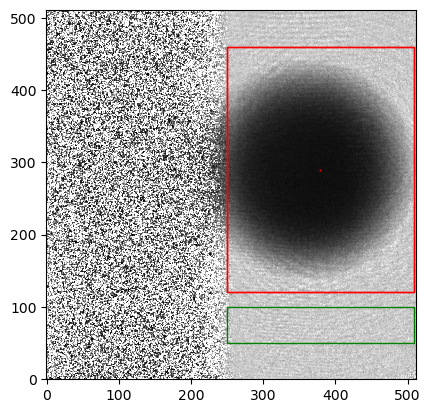

Displaying image: 
/Users/huanbui/Desktop/sample_data/lf/1246938_2023-02-09--10-20-37_Side.fits

Frame type: FakeOD


In [549]:
# initializes data frame and load metadata & exp params:
data_frame_ODT_LF, metadata_dict_ODT_LF, experiment_parameters_dict_ODT_LF = init_dataframe_metadata_and_exp_params()

# ROI Box and norm_box for ODT LF
ROI_ODT_LF = [250, # x min
              509, # x max
              120, # y min
              460] # y max

# Li LF Norm Box (ODT):
norm_box_ODT_LF = [250, # x min
                   509, # x max
                   50,  # y min
                   100] # y max

# add background-subtracted FakeOD ROI to dataframe:
data_frame_ODT_LF = add_backgroud_subtracted_ROI_to_dataframe_fast(data_frame_ODT_LF, ROI_ODT_LF, norm_box_ODT_LF)


# display Li LF image:
frame_type_ODT_LF = 'FakeOD'
current_file_fullpath_ODT_LF = data_frame_ODT_LF['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_ODT_LF, ROI_ODT_LF, norm_box_ODT_LF, frame_type_ODT_LF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_LF)
print('')
print('Frame type: ' + frame_type_ODT_LF)

## <font color=#399FD5>Li ODT LF pixel sums and resonance curve fitting</font>

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 533.09it/s]

----------Fit result----------------
Amplitude: 87212.71 +/- 1239.46
Center: -370.82 +/- 0.05
Gamma prime: 7.08 +/- 0.20
Offset: 71.29 +/- 1064.29
Calculated saturation parameter: 0.45
------------------------------------
Set value in Cicero to: 185.41


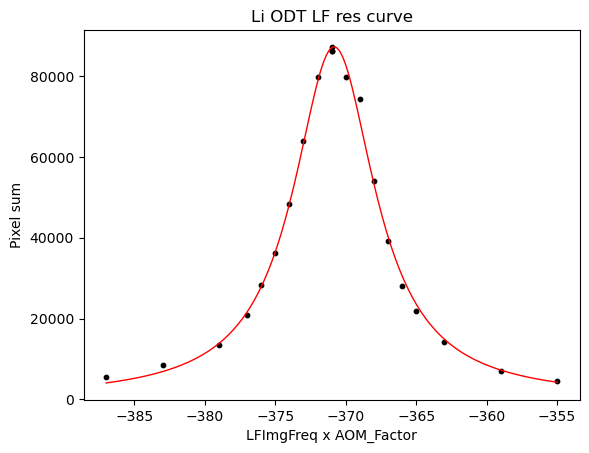

{'amplitude': 87212.71281262595, 'center': -370.8239984267977, 'gamma prime': 7.076160938727323, 'offset': 71.28738317918949, 'calculated saturation parameter': 0.45199173309921004}


In [550]:
# compute, for each shot, a pixel sum
data_frame_ODT_LF = add_pixel_sums_to_data_frame_from_FakeOD_ROI(data_frame_ODT_LF)

# get pixel sums and RF freqs from dataframe:
pixel_sums_ODT_LF = data_frame_ODT_LF['pixel_sum']
img_freqs_ODT_LF = data_frame_ODT_LF['LFImgFreq']

# ODT LF: 
center_guess_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_res_freq']
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']

fit_result_ODT_LF = Li_resonance_imaging_curve_fit(img_freqs_ODT_LF, 
                               pixel_sums_ODT_LF, 
                               AOM_factor_ODT_LF,
                               center_guess_ODT_LF,
                               plot_xlabel = 'LFImgFreq x AOM_Factor',
                               plot_title = 'Li ODT LF res curve')

print(fit_result_ODT_LF)

## <font color=#399FD5>Li ODT LF atom counting</font>

### <font color=#6C828D>Get densities and atom counts</font>

In [551]:
# get imaging parameters here:
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']
omega0_ODT_LF = fit_result_ODT_LF['center']/AOM_factor_ODT_LF
saturation_parameter_ODT_LF = fit_result_ODT_LF['calculated saturation parameter']
um_per_pixel_ODT_LF = experiment_parameters_dict_ODT_LF['Values']['side_low_mag_um_per_pixel'] # in um

# get densities:
data_frame_ODT_LF = add_atom_densities_abs_to_data_frame_Side_LF_fast(data_frame_ODT_LF, 
                                                                      sigma0 = Li6D2sigma0,
                                                                      Gamma = Li6D2Gamma, 
                                                                      s = saturation_parameter_ODT_LF, 
                                                                      omega0 = omega0_ODT_LF,
                                                                      AOM_factor = AOM_factor_ODT_LF)

# now get counts from this:
data_frame_ODT_LF = add_atom_counts_from_densities_to_data_frame(data_frame_ODT_LF, 
                                                                 um_per_pixel_ODT_LF)

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 495.38it/s]


### <font color=#6C828D>Plot counts</font>

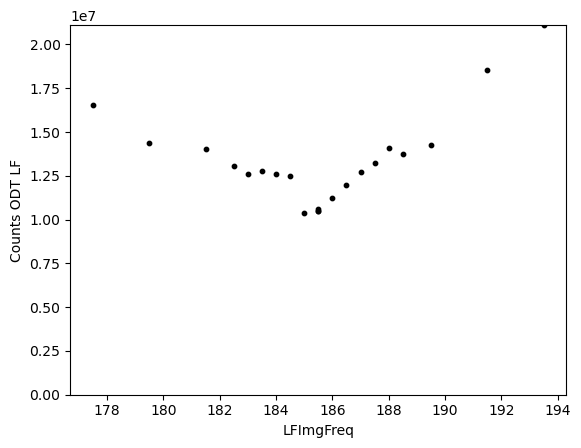

In [552]:
atom_counts_ODT_LF = data_frame_ODT_LF['atom_count']
        
plt.scatter(img_freqs_ODT_LF, atom_counts_ODT_LF, color = 'black', s=10)
plt.ylim([0, max(atom_counts_ODT_LF)])
plt.xlabel('LFImgFreq')
plt.ylabel('Counts ODT LF')
plt.show()

# Li ODT Top HF Resonance Curve (Abs)

## <font color=#399FD5>Data preview and preparation</font>

2023-03-08 16:57:42.133 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 16:57:42.136 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 16:57:43.906 python[75836:20428616] +[CATransaction synchronize] called within transaction


Current folder: /Volumes/Raw Data/Images/2023/2023-03/2023-03-08/odt_hf_res
Metadata loaded
Experiment parameters loaded
Data frame initialized!


Loading ROIs: 100%|█████████████████████████████| 36/36 [00:20<00:00,  1.75it/s]


All done.


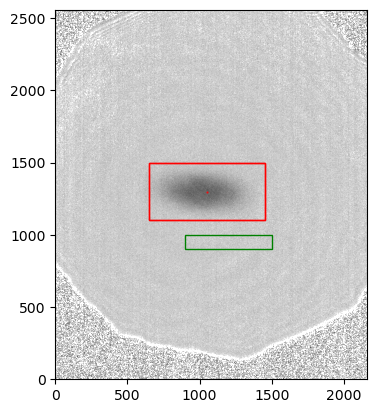

Displaying image: 
/Volumes/Raw Data/Images/2023/2023-03/2023-03-08/odt_hf_res/1267020_2023-03-08--16-44-15_TopA.fits

Frame type: FakeOD


In [346]:
# initializes data frame and load metadata & exp params:
data_frame_ODT_HF, metadata_dict_ODT_HF, experiment_parameters_dict_ODT_HF = init_dataframe_metadata_and_exp_params()

# ROI Box and norm_box for ODT HF
ROI_ODT_HF = [650,  # x min
              1450, # x max
              1100, # y min
              1500] # y max

# Li HF Norm Box (ODT):
norm_box_ODT_HF = [900,  # x min
                   1500, # x max
                   900,  # y min
                   1000] # y max

# add background-subtracted FakeOD ROI to dataframe:
data_frame_ODT_HF = add_backgroud_subtracted_ROI_to_dataframe_fast(data_frame_ODT_HF, ROI_ODT_HF, norm_box_ODT_HF)

# display Li LF image:
frame_type_ODT_HF = 'FakeOD'
current_file_fullpath_ODT_HF = data_frame_ODT_HF['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_ODT_HF, ROI_ODT_HF, norm_box_ODT_HF, frame_type_ODT_HF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_HF)
print('')
print('Frame type: ' + frame_type_ODT_HF)

## <font color=#399FD5>Li ODT HF pixel sums and resonance curve fitting</font>

100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 168.06it/s]

----------Fit result----------------
Amplitude: 99699.33 +/- 7399.64
Center: -311.53 +/- 0.22
Gamma prime: 7.54 +/- 1.08
Offset: 20931.19 +/- 6017.67
Calculated saturation parameter: 0.65
------------------------------------
Set value in Cicero to: 155.76


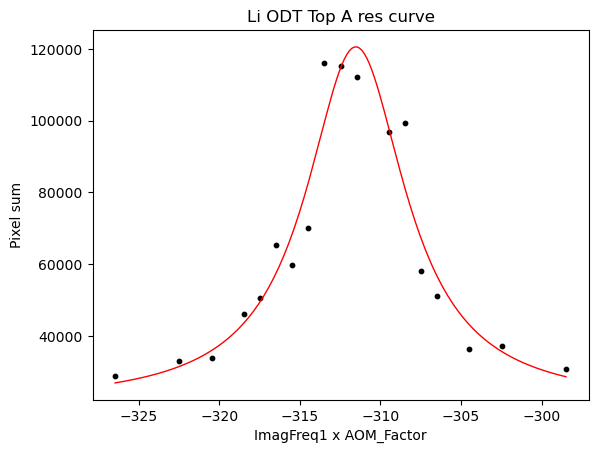

----------Fit result----------------
Amplitude: 120273.90 +/- 7876.35
Center: -472.84 +/- 0.20
Gamma prime: 7.33 +/- 0.91
Offset: 23105.35 +/- 6342.95
Calculated saturation parameter: 0.56
------------------------------------
Set value in Cicero to: 236.42


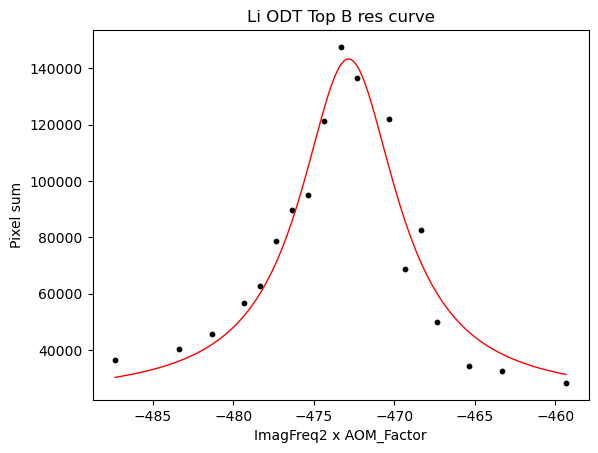

In [347]:
# compute, for each shot, a pixel sum
data_frame_ODT_HF = add_pixel_sums_to_data_frame_from_FakeOD_ROI(data_frame_ODT_HF)

# get pixel sums and RF freqs from dataframe:
pixel_sums_A_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopA']['pixel_sum']
img_freqs_A_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopA']['ImagFreq1']
pixel_sums_B_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopB']['pixel_sum']
img_freqs_B_ODT_HF = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopB']['ImagFreq2']

# ODT Top: 
center_guess_A = experiment_parameters_dict_ODT_HF['Values']['state_1_unitarity_res_freq_MHz']
center_guess_B = experiment_parameters_dict_ODT_HF['Values']['state_3_unitarity_res_freq_MHz']
AOM_factor = experiment_parameters_dict_ODT_HF['Values']['li_hf_freq_multiplier']

# Top A
fit_result_TopA = Li_resonance_imaging_curve_fit(img_freqs_A_ODT_HF, 
                               pixel_sums_A_ODT_HF, 
                               AOM_factor,
                               center_guess_A,       
                               plot_xlabel = 'ImagFreq1 x AOM_Factor',
                               plot_title = 'Li ODT Top A res curve')

# Top B
fit_result_TopB = Li_resonance_imaging_curve_fit(img_freqs_B_ODT_HF, 
                               pixel_sums_B_ODT_HF, 
                               AOM_factor,
                               center_guess_B,
                               plot_xlabel = 'ImagFreq2 x AOM_Factor',
                               plot_title = 'Li ODT Top B res curve')

## <font color=#399FD5>Li ODT HF atom counting</font>

### <font color=#6C828D>Get densities and atom counts</font>

In [344]:
# get imaging parameters here:
AOM_factor_ODT_HF = experiment_parameters_dict_ODT_HF["Values"]['li_hf_freq_multiplier']
omega0_ODT_HF_A = fit_result_TopA['center']/AOM_factor_ODT_HF # from fit
omega0_ODT_HF_B = fit_result_TopB['center']/AOM_factor_ODT_HF # from fit
saturation_parameter_ODT_HF_A = fit_result_TopA['calculated saturation parameter'] # from fit
saturation_parameter_ODT_HF_B = fit_result_TopB['calculated saturation parameter'] # from fit
um_per_pixel_ODT_HF = experiment_parameters_dict_ODT_HF['Values']['top_um_per_pixel'] # in um

# get densities:
data_frame_ODT_HF = add_atom_densities_abs_to_data_frame_TopAB_fast(data_frame_ODT_HF, 
                                                                    sigma0 = Li6D2sigma0,
                                                                    Gamma = Li6D2Gamma, 
                                                                    s_A = saturation_parameter_ODT_HF_A, 
                                                                    s_B = saturation_parameter_ODT_HF_B,
                                                                    omega0_A = omega0_ODT_HF_A,
                                                                    omega0_B = omega0_ODT_HF_B,
                                                                    AOM_factor = AOM_factor_ODT_HF)

# now get counts from this:
data_frame_ODT_HF = add_atom_counts_from_densities_to_data_frame(data_frame_ODT_HF, 
                                                                 um_per_pixel_ODT_HF)

100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 179.93it/s]


### <font color=#6C828D>Plot counts</font>

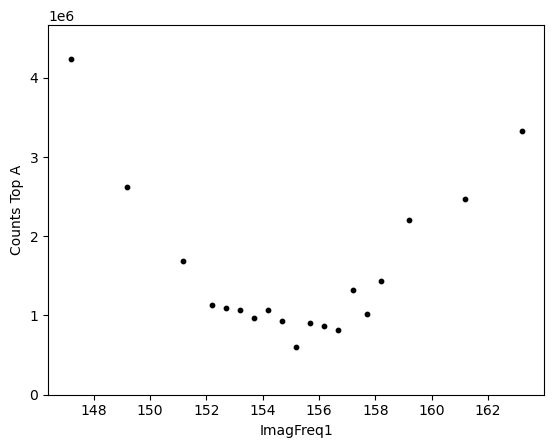

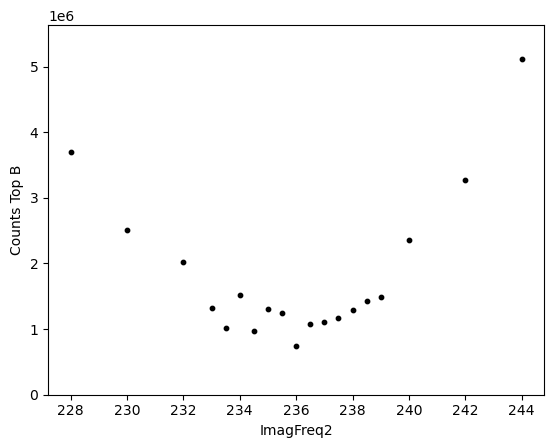

In [345]:
atom_counts_ODT_HF_A = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopA']['atom_count']
atom_counts_ODT_HF_B = data_frame_ODT_HF[data_frame_ODT_HF['image_type']=='TopB']['atom_count']

# plot results now        
plt.scatter(img_freqs_A_ODT_HF, atom_counts_ODT_HF_A, color = 'black',s=10)
plt.ylim([0, max(atom_counts_ODT_HF_A)*1.1])
plt.xlabel('ImagFreq1')
plt.ylabel('Counts Top A')
plt.show()

plt.scatter(img_freqs_B_ODT_HF, atom_counts_ODT_HF_B, color = 'black',s=10)
plt.ylim([0, max(atom_counts_ODT_HF_B)*1.1])
plt.xlabel('ImagFreq2')
plt.ylabel('Counts Top B')
plt.show()

# Li Hybrid Top: Box Exp Imbalance Curve (PR)

## <font color=#399FD5>Data preview and preparation</font>

2023-03-08 16:23:41.908 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 16:23:41.911 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 16:23:43.291 python[75836:20428616] +[CATransaction synchronize] called within transaction


Current folder: /Volumes/Raw Data/Images/2023/2023-03/2023-03-08/box_exp_RF12_3ms_post
Metadata loaded
Experiment parameters loaded
Data frame initialized!


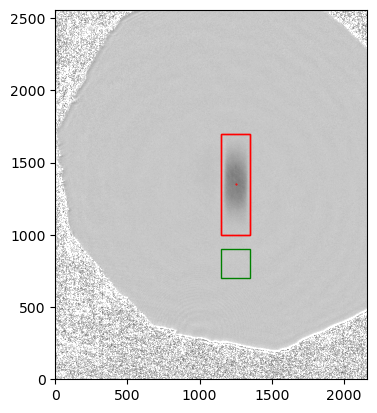

Displaying image: 
/Volumes/Raw Data/Images/2023/2023-03/2023-03-08/box_exp_RF12_3ms_post/1266986_2023-03-08--16-16-17_TopA.fits

Frame type: FakeOD


In [337]:
# initializes data frame and load metadata & exp params:
data_frame_Box_Exp_Imb_PR, metadata_dict_Box_Exp_Imb_PR, experiment_parameters_dict_Box_Exp_Imb_PR = init_dataframe_metadata_and_exp_params(['RF12_Time'])

# ROI Box
ROI_Box_Exp_Imb_PR = [1150,  # x min
          1350, # x max
          1000, # y min
          1700] # y max

# Norm box
norm_box_Box_Exp_Imb_PR = [1150,  # x min
               1350, # x max
               700,  # y min
               900] # y max

# display image:
frame_type_Box_Exp_Imb_PR = 'FakeOD'
current_file_fullpath_Box_Exp_Imb_PR = data_frame_Box_Exp_Imb_PR['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_Box_Exp_Imb_PR, 
                        ROI_Box_Exp_Imb_PR, 
                        norm_box_Box_Exp_Imb_PR, 
                        frame_type_Box_Exp_Imb_PR)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Box_Exp_Imb_PR)
print('')
print('Frame type: ' + frame_type_Box_Exp_Imb_PR)

## <font color=#399FD5>Get column densities and counts</font>

Loading ROIs: 100%|█████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


All done.


Solving images: 100%|█████████████████████████████| 8/8 [00:11<00:00,  1.50s/it]


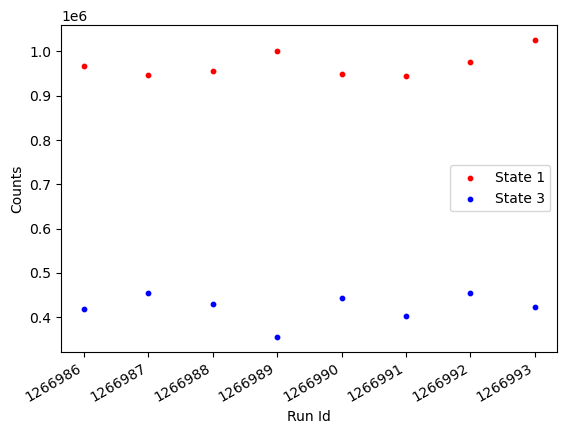

In [338]:
# add od_roi and od_norm_box to dataframe:
data_frame_Box_Exp_Imb_PR = add_backgroud_subtracted_ROI_to_dataframe_fast(data_frame_Box_Exp_Imb_PR, 
                                                                           ROI_Box_Exp_Imb_PR, 
                                                                           norm_box_Box_Exp_Imb_PR)
# get column densities
data_frame_Box_Exp_Imb_PR = add_polrot_column_densities_to_dataframe(data_frame_Box_Exp_Imb_PR, 
                                                                     experiment_parameters_dict_Box_Exp_Imb_PR, 
                                                                     ROI_Box_Exp_Imb_PR)
# get counts
um_per_pixel_Box_Exp_Imb_PR = experiment_parameters_dict_Box_Exp_Imb_PR['Values']['top_um_per_pixel'] # in um
data_frame_Box_Exp_Imb_PR = add_counts_from_PR_column_densities_to_dataframe(data_frame_Box_Exp_Imb_PR, 
                                                                             um_per_pixel_Box_Exp_Imb_PR)

# now plot counts versus run_id:
counts_A_Box_Exp_Imb_PR = data_frame_Box_Exp_Imb_PR[(data_frame_Box_Exp_Imb_PR['image_type'] == 'TopA')]['atom_count']
counts_B_Box_Exp_Imb_PR = data_frame_Box_Exp_Imb_PR[(data_frame_Box_Exp_Imb_PR['image_type'] == 'TopB')]['atom_count']
RF12_Times_Box_Exp_Imb = data_frame_Box_Exp_Imb_PR[(data_frame_Box_Exp_Imb_PR['image_type'] == 'TopA')]['RF12_Time']
run_ids_Box_Exp_Imb_PR = data_frame_Box_Exp_Imb_PR[(data_frame_Box_Exp_Imb_PR['image_type'] == 'TopA')]['run_id']

fig_Box_Exp_Imb_PR_counts = plt.figure()
ax_Box_Exp_Imb_PR_counts = fig_Box_Exp_Imb_PR_counts.add_subplot(111)

# plot counts vs Run Id
pr1_Box_Exp_Imb = ax_Box_Exp_Imb_PR_counts.scatter(run_ids_Box_Exp_Imb_PR, 
                                                   counts_A_Box_Exp_Imb_PR, 
                                                   color = 'red' , 
                                                   s = 10)
pr2_Box_Exp_Imb = ax_Box_Exp_Imb_PR_counts.scatter(run_ids_Box_Exp_Imb_PR, 
                                                   counts_B_Box_Exp_Imb_PR, 
                                                   color = 'blue', 
                                                   s = 10)
plt.xlabel('Run Id')
ax_Box_Exp_Imb_PR_counts.legend([pr1_Box_Exp_Imb, pr2_Box_Exp_Imb],['State 1', 'State 3'])
fig_Box_Exp_Imb_PR_counts.autofmt_xdate()
plt.ylabel('Counts')
plt.show()

## <font color=#399FD5>Get imbalance from counts</font>

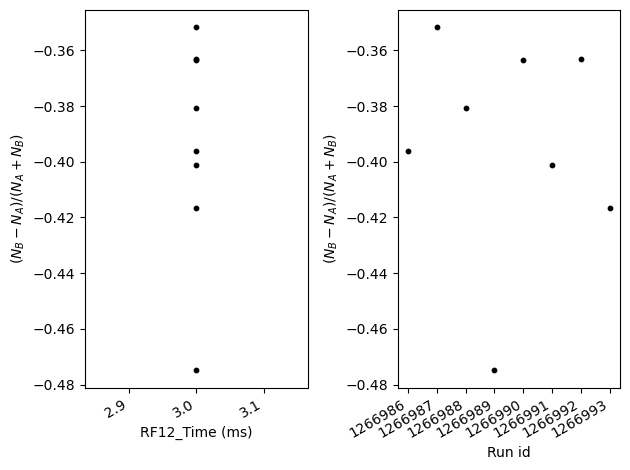

Average imbalance: -0.39345879217367463


In [339]:
# calculate imbalance vs Run Id
counts_A_Box_Exp_Imb_PR = np.array(counts_A_Box_Exp_Imb_PR)
counts_B_Box_Exp_Imb_PR = np.array(counts_B_Box_Exp_Imb_PR)
imbalance_PR = (counts_B_Box_Exp_Imb_PR - counts_A_Box_Exp_Imb_PR)/(counts_A_Box_Exp_Imb_PR + counts_B_Box_Exp_Imb_PR)

# plot imbalance vs RF12_Time:
fig_PR_imbalance_vs_RF12_Time = plt.figure()
ax_PR_imbalance_vs_RF12_Time = fig_PR_imbalance_vs_RF12_Time.add_subplot(121)
ax_PR_imbalance_vs_RF12_Time.scatter(RF12_Times_Box_Exp_Imb, imbalance_PR, color = 'black', s = 10)
fig_PR_imbalance_vs_RF12_Time.autofmt_xdate()
plt.xlabel('RF12_Time (ms)')
plt.ylabel('$(N_B-N_A)/(N_A+N_B)$')

# plot imbalance vs run_id as well:
ax_PR_imbalance_vs_run_id = fig_PR_imbalance_vs_RF12_Time.add_subplot(122)
ax_PR_imbalance_vs_run_id.scatter(run_ids_Box_Exp_Imb_PR, imbalance_PR, color = 'black', s=10)
fig_PR_imbalance_vs_RF12_Time.autofmt_xdate()
plt.xlabel('Run id')
plt.ylabel('$(N_B-N_A)/(N_A+N_B)$')

fig_PR_imbalance_vs_RF12_Time.tight_layout()
plt.show()

# print average imbalance:
print('Average imbalance: ' + str(np.mean(imbalance_PR)))

# Li Hybrid Top: Compressibility (PR)

## <font color=#399FD5>Data preview and preparation</font>

2023-03-08 16:29:18.218 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 16:29:18.224 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 16:29:19.840 python[75836:20428616] +[CATransaction synchronize] called within transaction


Current folder: /Volumes/Raw Data/Images/2023/2023-03/2023-03-08/box_exp_RF12_3ms_post
Metadata loaded
Experiment parameters loaded
Data frame initialized!


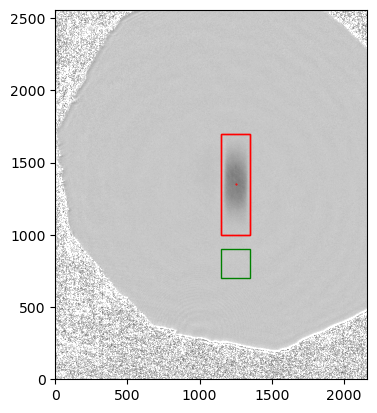

Displaying image: 
/Volumes/Raw Data/Images/2023/2023-03/2023-03-08/box_exp_RF12_3ms_post/1266986_2023-03-08--16-16-17_TopA.fits

Frame type: FakeOD


In [340]:
# initializes data frame and load metadata & exp params:
data_frame_Hybrid_Top_PR, metadata_dict_Hybrid_Top_PR, experiment_parameters_dict_Hybrid_Top_PR = init_dataframe_metadata_and_exp_params(['RF12_Time'])

# ROI Box
ROI_Hybrid_Top_PR = [1150,  # x min
          1350, # x max
          1000, # y min
          1700] # y max

# Norm box
norm_box_Hybrid_Top_PR = [1150,  # x min
               1350, # x max
               700,  # y min
               900] # y max

# display image:
frame_type_Hybrid_Top_PR = 'FakeOD'
current_file_fullpath_Hybrid_Top_PR = data_frame_Hybrid_Top_PR['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_Hybrid_Top_PR, 
                        ROI_Hybrid_Top_PR, 
                        norm_box_Hybrid_Top_PR, 
                        frame_type_Hybrid_Top_PR)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Hybrid_Top_PR)
print('')
print('Frame type: ' + frame_type_Hybrid_Top_PR)

## <font color=#399FD5>Get column densities and counts</font>

Loading ROIs: 100%|█████████████████████████████| 16/16 [00:29<00:00,  1.86s/it]


All done.


Solving images: 100%|█████████████████████████████| 8/8 [00:13<00:00,  1.69s/it]


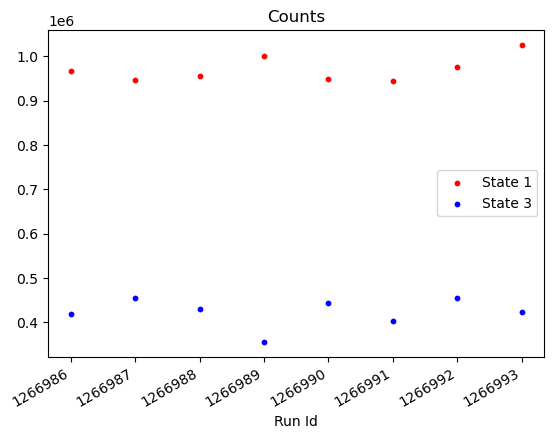

In [341]:
# add od_roi and od_norm_box to dataframe:
data_frame_Hybrid_Top_PR = add_backgroud_subtracted_ROI_to_dataframe_fast(data_frame_Hybrid_Top_PR, 
                                                                          ROI_Hybrid_Top_PR, norm_box_Hybrid_Top_PR)
# get column densities
data_frame_Hybrid_Top_PR = add_polrot_column_densities_to_dataframe(data_frame_Hybrid_Top_PR, 
                                                                     experiment_parameters_dict_Hybrid_Top_PR, 
                                                                     ROI_Hybrid_Top_PR)
# get counts
um_per_pixel_Hybrid_Top_PR = experiment_parameters_dict_Hybrid_Top_PR['Values']['top_um_per_pixel'] # in um
data_frame_Hybrid_Top_PR = add_counts_from_PR_column_densities_to_dataframe(data_frame_Hybrid_Top_PR, 
                                                                             um_per_pixel_Hybrid_Top_PR)

# now plot counts versus run_id:
run_ids_Hybrid_Top_PR = data_frame_Hybrid_Top_PR[data_frame_Hybrid_Top_PR['image_type']=='TopA']['run_id']
RF12_Times_Hybrid_Top = data_frame_Hybrid_Top_PR[data_frame_Hybrid_Top_PR['image_type']=='TopA']['RF12_Time']
counts_A_Hybrid_Top_PR = data_frame_Hybrid_Top_PR[data_frame_Hybrid_Top_PR['image_type']=='TopA']['atom_count']
counts_B_Hybrid_Top_PR = data_frame_Hybrid_Top_PR[data_frame_Hybrid_Top_PR['image_type']=='TopB']['atom_count']
        
fig_Hybrid_Top_PR_counts = plt.figure()
ax_Hybrid_Top_PR_counts = fig_Hybrid_Top_PR_counts.add_subplot(111)

# plot counts vs Run Id
pr1_Hybrid_Top = ax_Hybrid_Top_PR_counts.scatter(run_ids_Hybrid_Top_PR, 
                                                   counts_A_Hybrid_Top_PR, 
                                                   color = 'red' , 
                                                   s = 10)
pr2_Hybrid_Top = ax_Hybrid_Top_PR_counts.scatter(run_ids_Hybrid_Top_PR, 
                                                   counts_B_Hybrid_Top_PR, 
                                                   color = 'blue', 
                                                   s = 10)
plt.xlabel('Run Id')
ax_Hybrid_Top_PR_counts.legend([pr1_Hybrid_Top, pr2_Hybrid_Top],['State 1', 'State 3'])
fig_Hybrid_Top_PR_counts.autofmt_xdate()
plt.title('Counts')
plt.show()

## <font color=#399FD5>Get imbalance from counts</font>

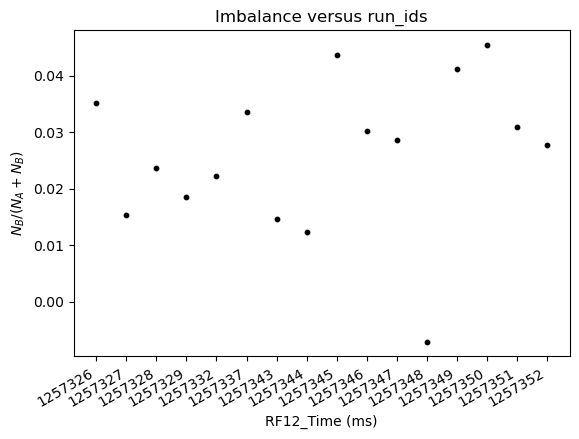

In [46]:
# calculate imbalance vs Run Id
counts_A_Hybrid_Top_PR = np.array(counts_A_Hybrid_Top_PR)
counts_B_Hybrid_Top_PR = np.array(counts_B_Hybrid_Top_PR)
imbalance_Hybrid_Top_PR = (counts_B_Hybrid_Top_PR - counts_A_Hybrid_Top_PR)/(counts_A_Hybrid_Top_PR + counts_B_Hybrid_Top_PR)
# plot imbalance vs run_ids:
fig_Hybrid_Top_PR_imbalance_vs_run_ids = plt.figure()
ax_Hybrid_Top_PR_imbalance_vs_run_ids = fig_Hybrid_Top_PR_imbalance_vs_run_ids.add_subplot(111)
ax_Hybrid_Top_PR_imbalance_vs_run_ids.scatter(run_ids_Hybrid_Top_PR, 
                                              imbalance_Hybrid_Top_PR, 
                                              color = 'black', s = 10)
fig_Hybrid_Top_PR_imbalance_vs_run_ids.autofmt_xdate()
plt.title('Imbalance versus run_ids')
plt.xlabel('RF12_Time (ms)')
plt.ylabel('$N_B/(N_A+N_B)$')
plt.show()

## <font color=#399FD5>Justify images by tilt angle</font>

Tilt angle: 0.0 degrees


100%|████████████████████████████████████████| 32/32 [00:00<00:00, 10853.77it/s]


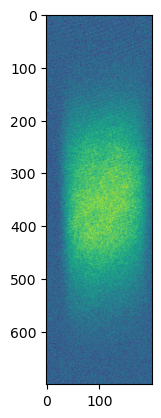

In [47]:
# justify imaging by tilting
hybrid_top_tilt_angle = experiment_parameters_dict_Hybrid_Top_PR["Values"]["axicon_tilt_deg"]
# override to for testing
hybrid_top_tilt_angle = 0.0

data_frame_Hybrid_Top_PR = add_justified_column_density_to_dataframe(data_frame_Hybrid_Top_PR, hybrid_top_tilt_angle)

# look at a rotated image:
plt.imshow(data_frame_Hybrid_Top_PR['justified_column_density'][5])
plt.show()

## <font color=#399FD5>Get densities along harmonic trap axis $n_{\text{3D}}(z)$ and trap centers</font>

In [52]:
# add n3d along harmonic axis of hybrid trap to df
data_frame_Hybrid_Top_PR = add_n3d_along_harmonic_axis_to_dataframe(data_frame_Hybrid_Top_PR,
                                                                    experiment_parameters_dict_Hybrid_Top_PR)
# add harmonic trap centers to df
data_frame_Hybrid_Top_PR = add_hybrid_harmonic_trap_centers_to_dataframe(data_frame_Hybrid_Top_PR)

100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 946.21it/s]


# Li Box Top: Sound Scan (PR)

## <font color=#399FD5>Data preview and preparation</font>

2023-03-08 15:47:48.822 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 15:47:48.826 python[75836:20428616] +[CATransaction synchronize] called within transaction
2023-03-08 15:47:50.381 python[75836:20428616] +[CATransaction synchronize] called within transaction


Current folder: /Volumes/Raw Data/Images/2023/2023-03/2023-03-06/box_shake_RF24_ms
Metadata loaded
Experiment parameters loaded
Data frame initialized!


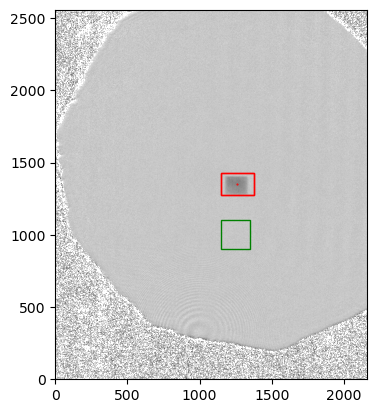

Displaying image: 
/Volumes/Raw Data/Images/2023/2023-03/2023-03-06/box_shake_RF24_ms/1264111_2023-03-06--13-52-54_TopA.fits

Frame type: FakeOD


In [274]:
# initializes data frame and load metadata & exp params:
data_frame_Sound_Scan_PR, metadata_dict_Sound_Scan_PR, experiment_parameters_dict_Sound_Scan_PR = init_dataframe_metadata_and_exp_params(['RF12_Time', 
                                                                                                                                          'ShakingCycles', 
                                                                                                                                          'BoxShakeFreq'])
# xmin, xmax, ymin, ymax
ROI_Sound_Scan_PR = [1150, 1375, 1275, 1425]
norm_box_Sound_Scan_PR = [1150, 1350, 900, 1100]

# display image:
frame_type_Sound_Scan_PR = 'FakeOD'
current_file_fullpath_Sound_Scan_PR = data_frame_Sound_Scan_PR['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_Sound_Scan_PR, 
                        ROI_Sound_Scan_PR, 
                        norm_box_Sound_Scan_PR, 
                        frame_type_Sound_Scan_PR)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Sound_Scan_PR)
print('')
print('Frame type: ' + frame_type_Sound_Scan_PR)

## <font color=#399FD5>Get column densities, counts, and imbalance</font>

In [304]:
# add od_roi and od_norm_box to dataframe:
data_frame_Sound_Scan_PR = add_backgroud_subtracted_ROI_to_dataframe_fast(data_frame_Sound_Scan_PR, 
                                                                           ROI_Sound_Scan_PR, 
                                                                           norm_box_Sound_Scan_PR)

# get column densities
data_frame_Sound_Scan_PR = add_polrot_column_densities_to_dataframe(data_frame_Sound_Scan_PR, 
                                                                     experiment_parameters_dict_Sound_Scan_PR, 
                                                                     ROI_Sound_Scan_PR)

Loading ROIs: 100%|███████████████████████████| 306/306 [04:00<00:00,  1.27it/s]


All done.


Solving images: 100%|█████████████████████████| 153/153 [00:44<00:00,  3.42it/s]


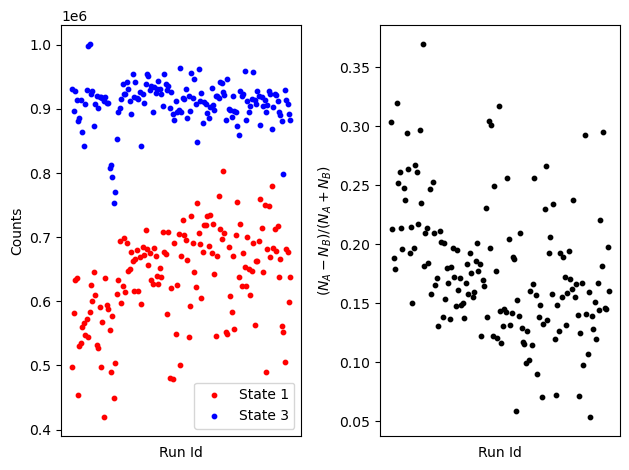

In [307]:
# get counts
um_per_pixel_Sound_Scan_PR = experiment_parameters_dict_Sound_Scan_PR['Values']['top_um_per_pixel'] # in um
data_frame_Sound_Scan_PR = add_counts_from_PR_column_densities_to_dataframe(data_frame_Sound_Scan_PR, 
                                                                             um_per_pixel_Sound_Scan_PR)

# get counts and run_ids
counts_A_Sound_Scan_PR = data_frame_Sound_Scan_PR[data_frame_Sound_Scan_PR['image_type']=='TopA']['atom_count']
counts_B_Sound_Scan_PR = data_frame_Sound_Scan_PR[data_frame_Sound_Scan_PR['image_type']=='TopB']['atom_count']
run_ids_Sound_Scan_PR  = data_frame_Sound_Scan_PR[data_frame_Sound_Scan_PR['image_type']=='TopA']['run_id']
        
fig_Sound_Scan_counts_and_imbalance = plt.figure()
ax_Sound_Scan_PR_counts = fig_Sound_Scan_counts_and_imbalance.add_subplot(121)

# plot counts vs Run Id
pr1_Sound_Scan = ax_Sound_Scan_PR_counts.scatter(run_ids_Sound_Scan_PR, 
                                                   counts_A_Sound_Scan_PR, 
                                                   color = 'red' , 
                                                   s = 10)
pr2_Sound_Scan = ax_Sound_Scan_PR_counts.scatter(run_ids_Sound_Scan_PR, 
                                                   counts_B_Sound_Scan_PR, 
                                                   color = 'blue', 
                                                   s = 10)
plt.xlabel('Run Id')
plt.ylabel('Counts')
ax_Sound_Scan_PR_counts.legend([pr1_Sound_Scan, pr2_Sound_Scan],['State 1', 'State 3'])
ax_Sound_Scan_PR_counts.set_xticks([])
fig_Sound_Scan_counts_and_imbalance.autofmt_xdate()

# plot imbalance versus run id:
counts_A_Sound_Scan_PR = np.array(counts_A_Sound_Scan_PR)
counts_B_Sound_Scan_PR = np.array(counts_B_Sound_Scan_PR)
imbalance_Sound_Scan = (counts_B_Sound_Scan_PR - counts_A_Sound_Scan_PR)/(counts_B_Sound_Scan_PR + counts_A_Sound_Scan_PR)

ax_Sound_Scan_PR_imbalance = fig_Sound_Scan_counts_and_imbalance.add_subplot(122)
imb_Sound_Scan_plot = ax_Sound_Scan_PR_imbalance.scatter(run_ids_Sound_Scan_PR,
                                                        imbalance_Sound_Scan,
                                                        color = 'black',
                                                        s=10)
plt.xlabel('Run Id')
plt.ylabel('$(N_A-N_B)/(N_A+N_B)$')
ax_Sound_Scan_PR_imbalance.set_xticks([])
fig_Sound_Scan_counts_and_imbalance.tight_layout()
plt.show()

## <font color=#399FD5>Justify images and get densities along harmonic trap axis</font>

Tilt angle: 0.0 degrees


100%|██████████████████████████████████████| 306/306 [00:00<00:00, 21979.64it/s]


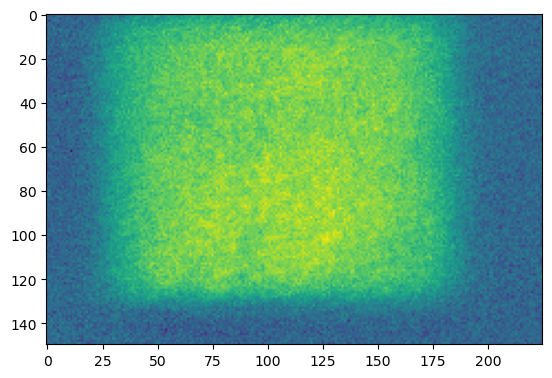

In [308]:
# justify imaging by tilting
box_top_tilt_angle = experiment_parameters_dict_Sound_Scan_PR["Values"]["axicon_tilt_deg"]

data_frame_Sound_Scan_PR = add_justified_column_density_to_dataframe(data_frame_Sound_Scan_PR, 
                                                                     box_top_tilt_angle)

# look at a rotated image:
plt.imshow(data_frame_Sound_Scan_PR['justified_column_density'][5])
plt.show()

# add n3d along harmonic axis of hybrid trap to df
data_frame_Sound_Scan_PR = add_n3d_along_harmonic_axis_to_dataframe(data_frame_Sound_Scan_PR,
                                                                    experiment_parameters_dict_Sound_Scan_PR)

## <font color=#399FD5>Subtract no-shake from shake</font>

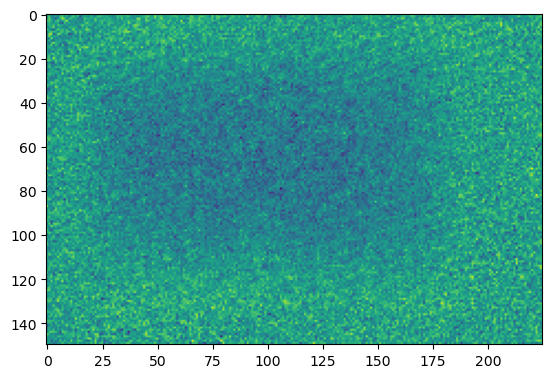

In [309]:
# extract the no shaking justified_column_densities:
if 'justified_column_density' in data_frame_Sound_Scan_PR.columns:
        
    no_shake_justified_density_A = data_frame_Sound_Scan_PR[(data_frame_Sound_Scan_PR['image_type'] == 'TopA') & 
                                                            (data_frame_Sound_Scan_PR['ShakingCycles'] == 0)]['justified_column_density']
    no_shake_justified_density_B = data_frame_Sound_Scan_PR[(data_frame_Sound_Scan_PR['image_type'] == 'TopB') & 
                                                            (data_frame_Sound_Scan_PR['ShakingCycles'] == 0)]['justified_column_density']
    
# now take average of all no shake shots:
avg_no_shake_justified_density_A = sum(no_shake_justified_density_A)/len(no_shake_justified_density_A)
avg_no_shake_justified_density_B = sum(no_shake_justified_density_B)/len(no_shake_justified_density_B)

# now subtract shake from no shake:
no_shake_subtracted = []
for idx, row in data_frame_Sound_Scan_PR.iterrows():
    if row['image_type'] == 'TopA':
        no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_justified_density_A)
    if row['image_type'] == 'TopB':
        no_shake_subtracted.append(row['justified_column_density'] - avg_no_shake_justified_density_B)
        
data_frame_Sound_Scan_PR['no_shake_subtracted'] = no_shake_subtracted
        
# show a no_shake_subtracted shot:
plt.imshow(data_frame_Sound_Scan_PR['no_shake_subtracted'][53])
plt.show()

# now get subtracted 3d density along harmonic axis
data_frame_Sound_Scan_PR = add_delta_n3d_with_no_shake_subtracted_to_dataframe(data_frame_Sound_Scan_PR, 
                                                                               experiment_parameters_dict_Sound_Scan_PR)


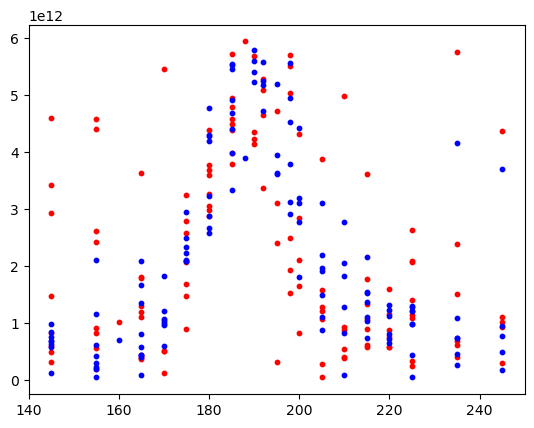

In [332]:
# loop through no_shake_subtracted_density and get amplitude for 1st symmetric mode:
fourier_amplitudes_AB = []


for idx, row in data_frame_Sound_Scan_PR.iterrows():
    density_FT = fft(row['no_shake_subtracted_integrated'])
    fourier_amplitudes = np.abs(density_FT)
    if row['image_type'] == 'TopA':
        fourier_amplitudes_AB.append(fourier_amplitudes[1])
    if row['image_type'] == 'TopB':
        fourier_amplitudes_AB.append(fourier_amplitudes[1])

data_frame_Sound_Scan_PR['fourier_amplitudes'] = fourier_amplitudes_AB

# get fourier amplitudes for each image type:
fourier_amplitudes_A = data_frame_Sound_Scan_PR[(data_frame_Sound_Scan_PR['image_type']=='TopA') &
                                                (data_frame_Sound_Scan_PR['good_shot'] == True) & 
                                                (data_frame_Sound_Scan_PR['ShakingCycles'] != 0)]['fourier_amplitudes']

fourier_amplitudes_B = data_frame_Sound_Scan_PR[(data_frame_Sound_Scan_PR['image_type']=='TopB') &
                                                (data_frame_Sound_Scan_PR['good_shot'] == True) & 
                                                (data_frame_Sound_Scan_PR['ShakingCycles'] != 0)]['fourier_amplitudes']

BoxShakeFreqs = data_frame_Sound_Scan_PR[(data_frame_Sound_Scan_PR['image_type']=='TopA') &
                                         (data_frame_Sound_Scan_PR['good_shot'] == True) & 
                                         (data_frame_Sound_Scan_PR['ShakingCycles'] != 0)]['BoxShakeFreq']

# now fiter data:
# data_frame_Sound_Scan_PR = data_filter(data_frame_Sound_Scan_PR, 'fourier_amplitudes', 2)

# can also reset data_filter:
# data_frame_Sound_Scan_PR = reset_data_filter(data_frame_Sound_Scan_PR)

# now plot fourier amplitudes against BoxShakeFreqs
plt.scatter(BoxShakeFreqs, fourier_amplitudes_A, color='red', s=10)
plt.scatter(BoxShakeFreqs, fourier_amplitudes_B, color='blue', s=10)

plt.show()

# Li Box Top: Traveling Waves

# RF Spectroscopy (Abs)

## <font color=#399FD5>Data preview and preparation</font>

2023-03-04 11:28:36.636 python[60586:19302445] +[CATransaction synchronize] called within transaction
2023-03-04 11:28:36.639 python[60586:19302445] +[CATransaction synchronize] called within transaction
2023-03-04 11:28:37.852 python[60586:19302445] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/RF12_spect_3
Metadata loaded
Experiment parameters loaded
Data frame initialized!


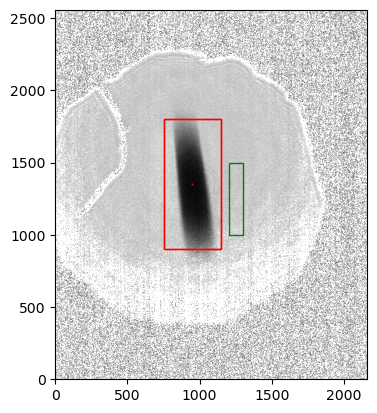

Extracting ROI...


100%|███████████████████████████████████████████| 68/68 [00:08<00:00,  7.77it/s]

All done.
Displaying image: 
/Users/huanbui/Desktop/sample_data/RF12_spect_3/1171463_2022-10-13--14-49-06_TopA.fits

Frame type: FakeOD


In [58]:
# initializes data frame and load metadata & exp params:
data_frame_RF_spec, metadata_dict_RF_spec, experiment_parameters_dict_RF_spec = init_dataframe_metadata_and_exp_params(['RF12_Box_Center', 'SpectPulseTime'])

# ROI Box and norm_box for RF spec
ROI_Li_RF_spec = [750,  # x min
                  1150, # x max 
                  900,  # y min 
                  1800] # y max

norm_box_Li_RF_spec = [1200, # x min
                       1300, # x max
                       1000, # y min
                       1500] # y max

# display some Li RF spec image:
frame_type_Li_RF_spec = 'FakeOD'
current_file_fullpath_Li_RF_spec = data_frame_RF_spec['fullpaths'][0]
fig_RF_spec, ax_RF_spec = display_image(current_file_fullpath_Li_RF_spec, ROI_Li_RF_spec, norm_box_Li_RF_spec, frame_type_Li_RF_spec)

# add background-subtracted FakeOD ROI to dataframe:
data_frame_RF_spec = add_backgroud_subtracted_ROI_to_dataframe_fast(data_frame_RF_spec, 
                                                                    ROI_Li_RF_spec, norm_box_Li_RF_spec)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Li_RF_spec)
print('')
print('Frame type: ' + frame_type_Li_RF_spec)

## <font color=#399FD5>Li RF transfer from pixel sum</font>

100%|██████████████████████████████████████████| 68/68 [00:00<00:00, 154.13it/s]


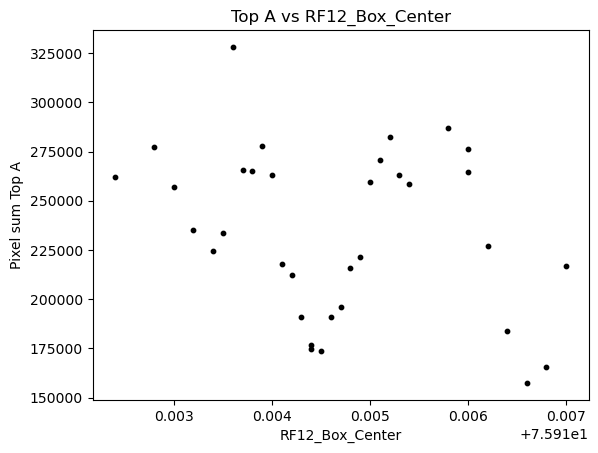

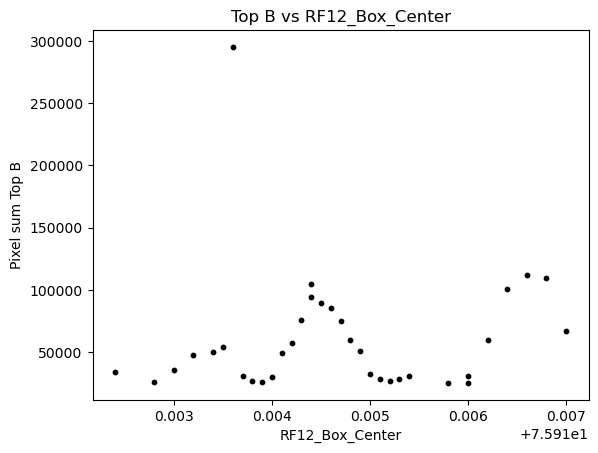

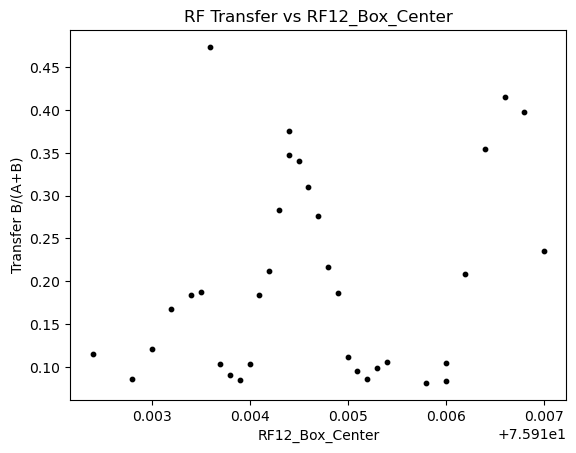

In [59]:
# compute, for each shot, a pixel sum
data_frame_RF_spec = add_pixel_sums_to_data_frame_from_FakeOD_ROI(data_frame_RF_spec)

# get pixel sums and RF freqs from dataframe:
pixel_sums_A_RF = np.array([])
pixel_sums_B_RF = np.array([])
RF_freqs_A = np.array([])
RF_freqs_B = np.array([])

# implement clever df manipulation here...
for index, row in data_frame_RF_spec.iterrows():
    if row['image_type'] == 'TopA':
        pixel_sums_A_RF = np.append(pixel_sums_A_RF, row['pixel_sum'])
        RF_freqs_A = np.append(RF_freqs_A, row['RF12_Box_Center'])
    elif row['image_type'] == 'TopB':
        pixel_sums_B_RF = np.append(pixel_sums_B_RF, row['pixel_sum'])
        RF_freqs_B = np.append(RF_freqs_B, row['RF12_Box_Center'])
        
# compute RF_transfer:
RF_transfer_pixel_sum = pixel_sums_B_RF/(pixel_sums_A_RF + pixel_sums_B_RF)

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs_A, pixel_sums_A_RF, color='black', s=10)
plt.xlabel('RF12_Box_Center')
plt.ylabel('Pixel sum Top A')
plt.title('Top A vs RF12_Box_Center')
plt.show()

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs_B, pixel_sums_B_RF, color='black', s=10)
plt.xlabel('RF12_Box_Center')
plt.ylabel('Pixel sum Top B')
plt.title('Top B vs RF12_Box_Center')
plt.show()

# plot transfer, using pixel sums:
plt.scatter(RF_freqs_A, RF_transfer_pixel_sum, color='black',s=10)
plt.xlabel('RF12_Box_Center')
plt.ylabel('Transfer B/(A+B)')
plt.title('RF Transfer vs RF12_Box_Center')
plt.show()


## <font color=#399FD5>Li RF transfer from atom count</font>

### <font color=#6C828D>Get densities and atom counts</font>

In [60]:
# get imaging parameters here:
AOM_factor_RF_spec = experiment_parameters_dict_RF_spec["Values"]['li_hf_freq_multiplier']
omega0_RF_spec_A = experiment_parameters_dict_RF_spec["Values"]['state_1_unitarity_res_freq_MHz']
omega0_RF_spec_B = experiment_parameters_dict_RF_spec["Values"]['state_2_unitarity_res_freq_MHz']
saturation_parameter_RF_spec_A = 0 # unknown, so assume 0
saturation_parameter_RF_spec_B = 0 # unknown, so assume 0
um_per_pixel_RF_spec = experiment_parameters_dict_RF_spec['Values']['top_um_per_pixel'] # in um

# get densities:
data_frame_RF_spec = add_atom_densities_abs_to_data_frame_TopAB_fast(data_frame_RF_spec, 
                                                                     sigma0 = Li6D2sigma0,
                                                                     Gamma = Li6D2Gamma, 
                                                                     s_A = saturation_parameter_RF_spec_A, 
                                                                     s_B = saturation_parameter_RF_spec_B,
                                                                     omega0_A = omega0_RF_spec_A,
                                                                     omega0_B = omega0_RF_spec_B,
                                                                     AOM_factor = AOM_factor_RF_spec)
# now get counts from densities:
data_frame_RF_spec = add_atom_counts_from_densities_to_data_frame(data_frame_RF_spec, 
                                                                  um_per_pixel_RF_spec)

100%|██████████████████████████████████████████| 68/68 [00:00<00:00, 162.75it/s]


### <font color=#6C828D>Calculate RF transfers and filter data</font>

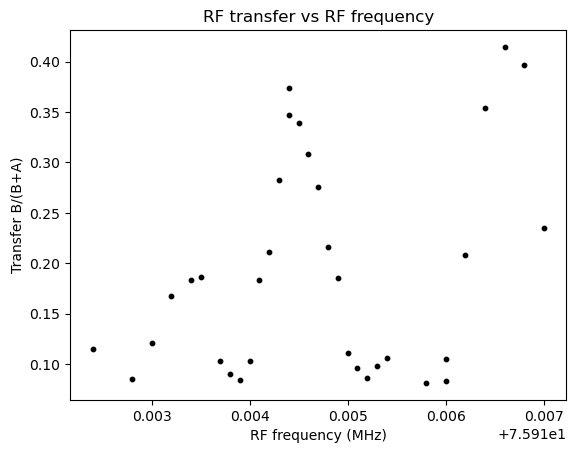

In [61]:
# get RF_transfers from counts:
atom_counts_RF_spec_A = np.array([])
atom_counts_RF_spec_B = np.array([])

# implement clever df maniulation to take data out...
for index, row in data_frame_RF_spec.iterrows():
    if row['image_type'] == 'TopA':
        atom_counts_RF_spec_A = np.append(atom_counts_RF_spec_A, row['atom_count'])
    elif row['image_type'] == 'TopB':
        atom_counts_RF_spec_B = np.append(atom_counts_RF_spec_B, row['atom_count'])

# compute RF_transfer:
RF_transfer_counts_B = atom_counts_RF_spec_B/(atom_counts_RF_spec_A + atom_counts_RF_spec_B)

# interweave the two lists like BB,BB,BB
RF_transfer_counts_BB = [None]*(RF_transfer_counts_B.size + RF_transfer_counts_B.size)
RF_transfer_counts_BB[::2] = RF_transfer_counts_B
RF_transfer_counts_BB[1::2] = RF_transfer_counts_B

# add RF transfers to data frame:
data_frame_RF_spec['RF_transfers_counts'] = RF_transfer_counts_BB

# call data filter here:
data_frame_RF_spec = data_filter(data_frame_RF_spec, 'RF_transfers_counts', 2)

# get good shot data:
RF_transfers_counts_good_shots = np.array([])
RF_freqs_good_shots = np.array([])
SpectPulseTimes_good_shot = np.array([])

# implement df manipulation here....
for index, row in data_frame_RF_spec.iterrows():
    if row['image_type'] == 'TopB' and row['good_shot']:
        RF_transfers_counts_good_shots = np.append(RF_transfers_counts_good_shots, row['RF_transfers_counts'])
        RF_freqs_good_shots = np.append(RF_freqs_good_shots, row['RF12_Box_Center'])
        SpectPulseTimes_good_shot = np.append(SpectPulseTimes_good_shot, row['SpectPulseTime'])

# plot RF transfer from atom counts:
plt.scatter(RF_freqs_good_shots, RF_transfers_counts_good_shots, color = 'black', s=10)
#plt.ylim([0, 1.1 * max(RF_transfer_counts)])
plt.title('RF transfer vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Transfer B/(B+A)')
plt.show()

## <font color=#399FD5>Li RF resonance curve fitting</font>

Some theory for this: The exact solution to the Rabi problem (without assuming spontaneous decay) is given by 

$P_2(\tau) = \frac{\omega_R^2}{\omega_R^2 + \delta^2} \sin^2\left( \tau  \frac{\sqrt{\delta^2 + \omega_R^2} }{2} \right), $ 


where we have assumed that initially $P_1 = 1$. Here $\tau$ is the width of the RF pulse, $\Omega_R$ is the bare Rabi frequency, and $\delta$ is the detuning. The setting in our case is that we know $\tau$ and $\delta$. So, the fit will tell us $\Omega_R$. 

For now, we will attempt to fit using the RF transfer computed using pixel summing. The method should work for atom counts once it is better-calibrated (i.e. once background "normalization" has been taken into account).


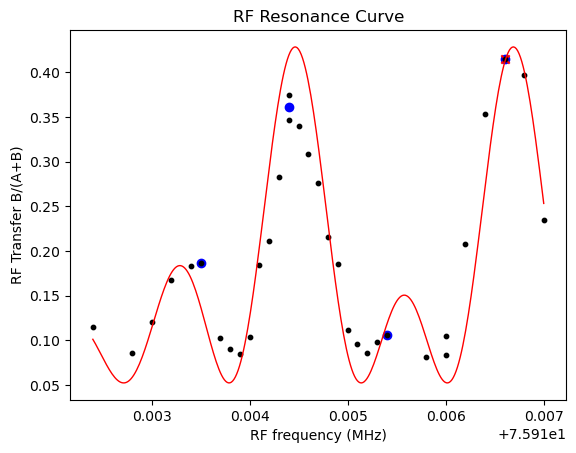

----------Fit result----------------
Rabi frequency: 0.000899 +/- 0.000012
Center: 75.91558 +/- 0.00002
Offset: 0.05226 +/- 0.00916


In [62]:
# now fit
fit_result_RF_spec = Li_P2_Rabi_RF_curve_fit((RF_freqs_good_shots, SpectPulseTimes_good_shot), 
                                             RF_transfers_counts_good_shots, 
                                             #omega0_guess =  np.average(RF_freqs_good_shots), # temp solution
                                             #omegaR_guess = 0.0005, # MHz 
                                             smart_guesses = True,
                                             peaks_ratio_threshold = 0.8,
                                             plot_xlabel = 'RF frequency (MHz)',
                                             plot_title = 'RF Resonance Curve')

# Residual Harmonic Trap Frequency with Axial Pluck (Abs)

## <font color=#399FD5>Data preview and preparation</font>

2023-03-04 23:34:23.807 python[60586:19302445] +[CATransaction synchronize] called within transaction
2023-03-04 23:34:23.811 python[60586:19302445] +[CATransaction synchronize] called within transaction
2023-03-04 23:34:25.571 python[60586:19302445] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/hyb_sloshing
Metadata loaded
Experiment parameters loaded
Data frame initialized!


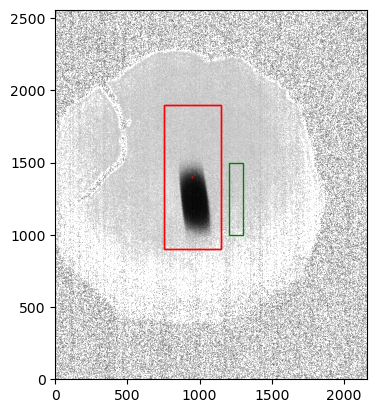

Extracting ROI...


100%|█████████████████████████████████████████| 144/144 [00:18<00:00,  7.85it/s]

All done.
Displaying image: 
/Users/huanbui/Desktop/sample_data/hyb_sloshing/1169409_2022-10-11--14-58-16_TopA.fits

Frame type: FakeOD


In [103]:
# initializes data frame and load metadata & exp params:
data_frame_AxPluck, metadata_dict_AxPluck, experiment_parameters_dict_AxPluck = init_dataframe_metadata_and_exp_params(['PluckWait'])

ROI_AxPluck = [750,  # x min
                  1150, # x max 
                  900,  # y min 
                  1900] # y max

norm_box_AxPluck = [1200, # x min
                       1300, # x max
                       1000, # y min
                       1500] # y max

frame_type_AxPluck = 'FakeOD'
current_file_fullpath_AxPluck = data_frame_AxPluck['fullpaths'][0]
fig_AxPluck, ax_AxPluck= display_image(current_file_fullpath_AxPluck, ROI_AxPluck, norm_box_AxPluck, frame_type_AxPluck)

# add background-subtracted FakeOD ROI to dataframe:
data_frame_AxPluck = add_backgroud_subtracted_ROI_to_dataframe_fast(data_frame_AxPluck, 
                                                                    ROI_AxPluck, norm_box_AxPluck)

#################################################
print('Displaying image: ')
print(current_file_fullpath_AxPluck)
print('')
print('Frame type: ' + frame_type_AxPluck)

## <font color=#399FD5>Get densities and counts</font>

In [104]:
# get imaging parameters here:
AOM_factor_AxPluck = experiment_parameters_dict_AxPluck["Values"]['li_hf_freq_multiplier']
omega0_AxPluck_A = experiment_parameters_dict_AxPluck["Values"]['state_1_unitarity_res_freq_MHz']
omega0_AxPluck_B = experiment_parameters_dict_AxPluck["Values"]['state_2_unitarity_res_freq_MHz']
saturation_parameter_AxPluck_A = 0 # unknown, so assume 0
saturation_parameter_AxPluck_B = 0 # unknown, so assume 0
um_per_pixel_AxPluck = experiment_parameters_dict_AxPluck['Values']['top_um_per_pixel'] # in um

# get densities from Top absorption imaging
data_frame_AxPluck = add_atom_densities_abs_to_data_frame_TopAB_fast(data_frame_AxPluck, 
                                                                     sigma0 = Li6D2sigma0,
                                                                     Gamma = Li6D2Gamma, 
                                                                     s_A = saturation_parameter_AxPluck_A, 
                                                                     s_B = saturation_parameter_AxPluck_B,
                                                                     omega0_A = omega0_AxPluck_A,
                                                                     omega0_B = omega0_AxPluck_B,
                                                                     AOM_factor = AOM_factor_AxPluck)
# now get counts from densities:
data_frame_AxPluck = add_atom_counts_from_densities_to_data_frame(data_frame_AxPluck, 
                                                                  um_per_pixel_AxPluck)

100%|████████████████████████████████████████| 144/144 [00:01<00:00, 129.51it/s]


## <font color=#399FD5>Justify images and get 3d densities along harmonic axis</font>

Tilt angle: 6.3 degrees


100%|█████████████████████████████████████████| 144/144 [00:08<00:00, 17.20it/s]


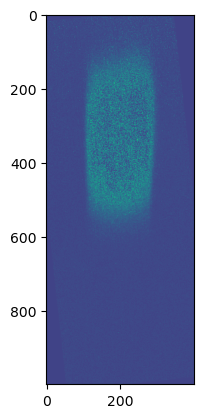

In [105]:
# justify image
AxPluck_tilt_angle = experiment_parameters_dict_AxPluck["Values"]["axicon_tilt_deg"]
data_frame_AxPluck = add_justified_column_density_to_dataframe(data_frame_AxPluck, AxPluck_tilt_angle)

# look at a rotated image:
plt.imshow(data_frame_AxPluck['justified_column_density'][5])
plt.show()

# add n3d along harmonic axis of hybrid trap and harmonic trap center to df
data_frame_AxPluck = add_n3d_along_harmonic_axis_to_dataframe(data_frame_AxPluck,
                                                                    experiment_parameters_dict_AxPluck)

## <font color=#399FD5>Get harmonic trap centers and find trapping frequency</font>

100%|████████████████████████████████████████| 144/144 [00:00<00:00, 567.89it/s]


----------Fit result----------------
Amplitude: 188.24 +/- 0.84
Center: 23.63 +/- 0.01
Phase: 0.48 +/- 0.00
Offset: 430.44 +/- 0.60


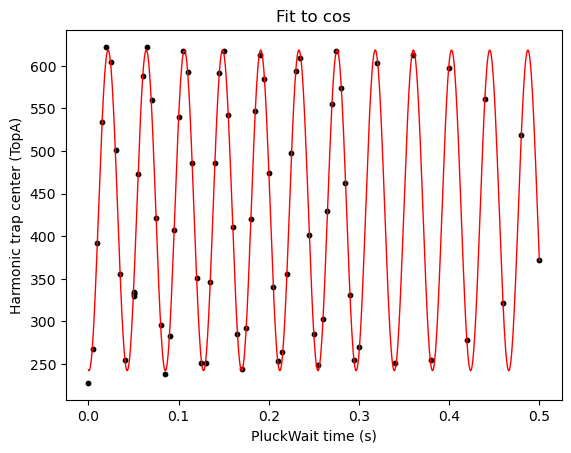

In [106]:
# add harmonic trap centers to df
data_frame_AxPluck = add_hybrid_harmonic_trap_centers_to_dataframe(data_frame_AxPluck)

# fit sloshing to get harmonic trap frequency from Top A shots:
pluck_wait_times = []
harmonic_trap_center_TopA = []
for idx, row in data_frame_AxPluck.iterrows():
    if row['image_type'] == 'TopA':
        pluck_wait_times.append(row['PluckWait'])
        harmonic_trap_center_TopA.append(row['hybrid_harmonic_trap_center'])

hyb_sloshing_fit_results = hybrid_sloshing_fit(pluck_wait_times, 
                                               harmonic_trap_center_TopA,
                                               plot_xlabel = 'PluckWait time (s)', 
                                               plot_ylabel = 'Harmonic trap center (TopA)',
                                               plot_title = 'Fit to cos')